## Les Pré-travaux

In [1]:
## Les Pré-travaux
import pandas as pd
## Pour une affiche plus large de certaines sorties
# Augmenter la largeur d'affichage pour voir toutes les colonnes
pd.set_option('display.max_columns', None)

# Augmenter le nombre de lignes affichées
pd.set_option('display.max_rows', None)

# Désactiver la coupure du texte
pd.set_option('display.max_colwidth', None)

In [14]:
# Pour la reproductibilité (fixer le germe)

import random
import numpy as np
import sklearn

def set_seed_sklearn(seed: int = 42):
    random.seed(seed)                 # Graine Python
    np.random.seed(seed)             # Graine NumPy
    try:
        sklearn.utils.check_random_state(seed) # pour les modèles sklearn utilisant joblib (random forests, etc)
    except:
        pass

# Utilisation
set_seed_sklearn(42)


In [3]:
!pip install ucimlrepo


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

df = pd.concat([X, y], axis=1)

# metadata 
print(breast_cancer_wisconsin_diagnostic.metadata) 
  
# variable information 
df.head()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


In [24]:
# Encodage de la variable cible : M = 1, B = 0
y=df['Diagnosis'] = df['Diagnosis'].map({'M': 0, 'B': 1})

# Vérification rapide
print(df['Diagnosis'].value_counts())

Diagnosis
1    357
0    212
Name: count, dtype: int64


# Partie 2: Implémentation d'un clustering sur la partie des caractéristiques de notre jeu de donnée

## I. Détermination des hyperparamètres optimales 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

def find_k_and_eps(df, k_max=10, min_pts_ratio=2.5, sample_max=2000, display=True):


    X = StandardScaler().fit_transform(df.values)



    if len(X) > sample_max:
        idx = np.random.choice(len(X), sample_max, replace=False)
        X_sample = X[idx]
    else:
        X_sample = X

    inertias, silhouettes, davies_bouldin = [], [], []
    K_values = range(2, k_max + 1)

    #  Recherche du meilleur K pour KMeans
    for k in K_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048)
        labels = kmeans.fit_predict(X_sample)

        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X_sample, labels))
        davies_bouldin.append(davies_bouldin_score(X_sample, labels))

    k_opt = K_values[int(np.argmax(silhouettes))] # Prends la valeur de K qui a donné le meilleur score silhouette

    #  Recherche de eps optimal pour DBSCAN
    minPts = int(df.shape[1] * min_pts_ratio)
    neigh = NearestNeighbors(n_neighbors=minPts, n_jobs=-1)
    nbrs = neigh.fit(X_sample)
    distances, _ = nbrs.kneighbors(X_sample)
    k_distances = np.sort(distances[:, -1])

    # Détection automatique du coude
    i = np.arange(len(k_distances))
    p1 = np.array([0, k_distances[0]])
    p2 = np.array([len(k_distances) - 1, k_distances[-1]])
    distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)
    eps_optimal = k_distances[np.argmax(distance_to_line)]

    #  Visualisation
    if display:
        plt.figure(figsize=(18, 5))

        plt.subplot(1, 3, 1)
        plt.plot(K_values, inertias, 'o-', label='Inertie')
        plt.axvline(k_opt, color='r', linestyle='--', label=f'K optimal = {k_opt}')
        plt.title("Méthode du coude (Inertie)")
        plt.xlabel("K")
        plt.ylabel("Inertie")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(K_values, silhouettes, 'o-', color='green', label='Silhouette')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Score Silhouette")
        plt.xlabel("K")
        plt.ylabel("Silhouette")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(K_values, davies_bouldin, 'o-', color='orange', label='Davies-Bouldin')
        plt.axvline(k_opt, color='r', linestyle='--')
        plt.title("Indice Davies-Bouldin (plus petit = meilleur)")
        plt.xlabel("K")
        plt.ylabel("Score")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # k-distance
        plt.figure(figsize=(6, 4))
        plt.plot(k_distances)
        plt.axhline(y=eps_optimal, color='r', linestyle='--', label=f"ε optimal = {eps_optimal:.4f}")
        plt.title(f"Courbe k-distance (minPts = {minPts})")
        plt.xlabel("Points triés")
        plt.ylabel(f"Distance au {minPts}ᵉ voisin")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Affichage
    print(f" K optimal trouvé : {k_opt}")
    print(f" Epsilon optimal trouvé : {eps_optimal:.4f}")
    print(f" minPts utilisé : {minPts}")

    return k_opt, eps_optimal


Nous allons écrire une fonction pour déterminer k et eps

Même si nous savons que k=2, nous somme currieux de savoir lequel est identifié par la méthode de coude comme étant l'optimal

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_18572\2110152141.py:46: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distance_to_line = np.abs(np.cross(p2 - p1, np.vstack((i, k_distances)).T - p1)) / np.linalg.norm(p2 - p1)


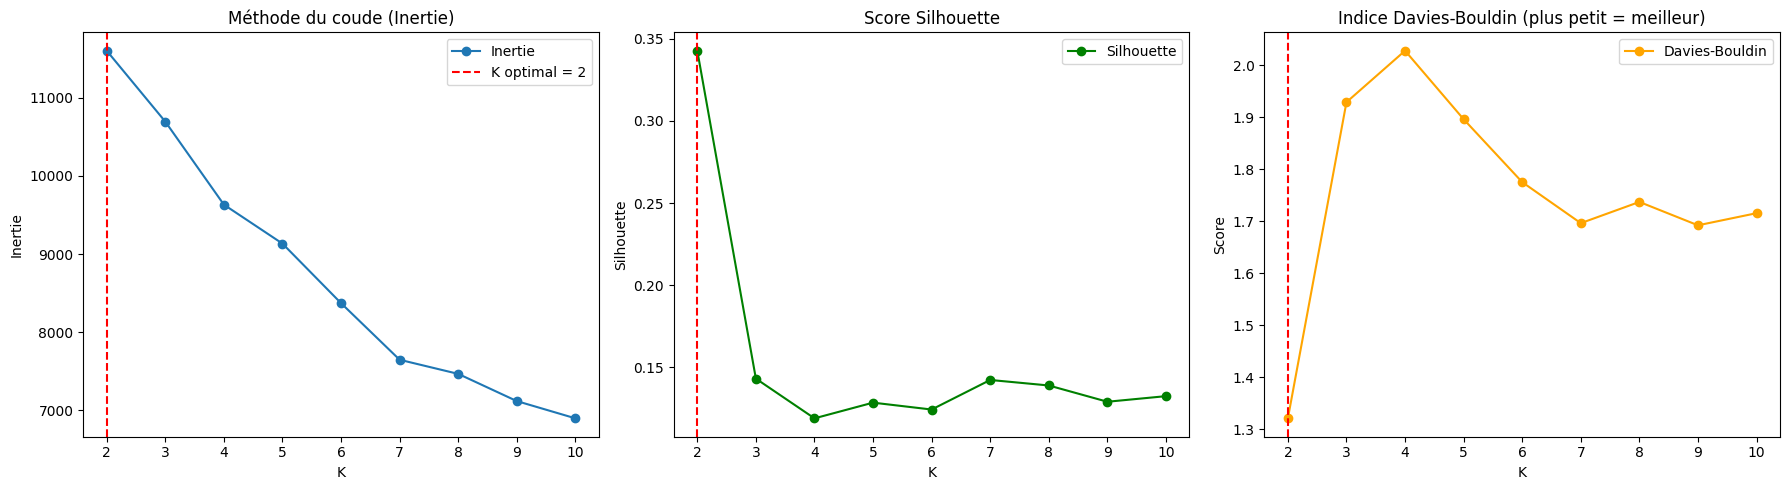

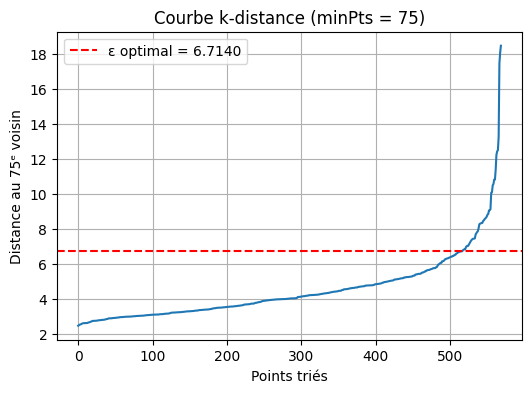

 K optimal trouvé : 2
 Epsilon optimal trouvé : 6.7140
 minPts utilisé : 75
K optimal = 2
Epsilon optimal = 6.7140462751456065


In [26]:
k, eps = find_k_and_eps(X,sample_max=569)
print("K optimal =", k)
print("Epsilon optimal =", eps)

Interprétation des résultats :

Sur le graphique du score Silhouette, la valeur maximale semble se situer autour de k=2 (score d'environ 0.30-0.35), ce qui confirme que k=2 est optimal car un score plus proche de 1 indique de meilleurs clusters.

Pour l'indice Davies-Bouldin, la valeur minimale apparaît également vers k=2, ce qui est cohérent puisque pour cet indice, plus la valeur est faible, meilleure est la séparation entre les clusters.

Ainsi, les trois métriques convergent :

Méthode du coude : k=2

Score Silhouette maximal : k=2

Indice Davies-Bouldin minimal : k=2

Conclusion : k=2 est clairement le choix optimal.

Cependant, k=7 est un candidat potentiel.

Sur le graphique d'inertie (méthode du coude), on observe un premier coude marqué à k=2, mais un second coude subtil apparaît vers k=7, où la décroissance de l'inertie ralentit à nouveau.

Pour le score Silhouette, bien que le maximum absolu soit à k=2, la valeur pour k=7 reste relativement correcte (environ 0.15-0.20), ce qui n'est pas négligeable.

L'indice Davies-Bouldin montre également une valeur basse pour k=7, comparable à d'autres k intermédiaires.

k=7 pourrait donc être un bon compromis mais pour notre étude , le domaine métier ne justifie pas  une segmentation plus fine.

Nous allons garder k=2 pour la suite de l'analyse.



## II. Comparaison de plusieurs algorithme de clustering 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import hdbscan
from scipy.spatial.distance import pdist, squareform

# Dunn Index 
def dunn_index(X, labels, max_points=3000):
    if len(X) > max_points:
        idx = np.random.choice(len(X), max_points, replace=False)
        X = X[idx]
        labels = labels[idx]
    distances = squareform(pdist(X))
    clusters = np.unique(labels)
    clusters = [c for c in clusters if c != -1]
    if len(clusters) < 2:
        return 0
    intra = max([np.max(distances[labels == c][:, labels == c]) for c in clusters])
    inter = np.min([
        distances[np.ix_(labels == c1, labels == c2)].min()
        for i, c1 in enumerate(clusters) for c2 in clusters[i + 1:]
    ])
    return inter / intra

#Stabilité
def stability_score(X, labels_func, runs=3, ratio=0.3):
    scores = []
    n = len(X)
    m = int(ratio * n)
    for _ in range(runs):
        idx1 = np.random.choice(n, m, replace=False)
        idx2 = np.random.choice(n, m, replace=False)
        l1 = labels_func(X[idx1])
        l2 = labels_func(X[idx2])
        min_len = min(len(l1), len(l2))
        s = np.mean(l1[:min_len] == l2[:min_len])
        scores.append(s)
    return np.mean(scores)




In [22]:
from sklearn.metrics import f1_score

def clustering_compare_full(X,y, k=2, eps=0.5, minPts=10,
                            algos=["kmeans", "dbscan", "hdbscan", "spectral"],
                            pca_components=None):
    print(" Standardisation des données...")
    X = StandardScaler().fit_transform(df.values)
    y_true = y  

    # PCA facultative
    if pca_components is not None and pca_components < X.shape[1]:
        print(f"Réduction PCA à {pca_components} composantes...")
        X = PCA(n_components=pca_components, random_state=42).fit_transform(X)

    results = {}
    print(" Exécution des algorithmes sur tout le dataset...")

    # KMeans
    if "kmeans" in algos:
        print(" MiniBatchKMeans...")
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=4096).fit(X)
        labels = kmeans.labels_
        results["KMeans"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: MiniBatchKMeans(
                n_clusters=k, random_state=42, batch_size=4096).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro")  #
        }
        results["KMeans"]["labels"] = labels

    # DBSCAN
    if "dbscan" in algos:
        print(" DBSCAN...")
        dbs = DBSCAN(eps=eps, min_samples=minPts, n_jobs=-1).fit(X)
        labels = dbs.labels_
        if len(set(labels)) > 1:
            results["DBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: DBSCAN(
                    eps=eps, min_samples=minPts, n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["DBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                 "Davies": float("inf"), "Stability": 0,
                                 "F1_macro": 0}
        results["DBSCAN"]["labels"] = labels

    # HDBSCAN
    if "hdbscan" in algos:
        print(" HDBSCAN...")
        hdb = hdbscan.HDBSCAN(min_cluster_size=minPts, core_dist_n_jobs=-1).fit(X)
        labels = hdb.labels_
        if len(set(labels)) > 1:
            results["HDBSCAN"] = {
                "CH": calinski_harabasz_score(X, labels),
                "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
                "Dunn": dunn_index(X, labels),
                "Davies": davies_bouldin_score(X, labels),
                "Stability": stability_score(X, lambda data: hdbscan.HDBSCAN(
                    min_cluster_size=minPts, core_dist_n_jobs=-1).fit(data).labels_),
                "F1_macro": f1_score(y_true, labels, average="macro")  # 
            }
        else:
            results["HDBSCAN"] = {"CH": 0, "Silhouette": 0, "Dunn": 0,
                                  "Davies": float("inf"), "Stability": 0,
                                  "F1_macro": 0}
        results["HDBSCAN"]["labels"] = labels

    # Spectral
    if "spectral" in algos:
        print(" Spectral Clustering...")
        sp = SpectralClustering(
            n_clusters=k, affinity='nearest_neighbors',
            assign_labels='kmeans', random_state=42, n_jobs=-1
        ).fit(X)
        labels = sp.labels_
        results["Spectral"] = {
            "CH": calinski_harabasz_score(X, labels),
            "Silhouette": silhouette_score(X, labels, sample_size=5000, random_state=42),
            "Dunn": dunn_index(X, labels),
            "Davies": davies_bouldin_score(X, labels),
            "Stability": stability_score(X, lambda data: SpectralClustering(
                n_clusters=k, affinity='nearest_neighbors', assign_labels='kmeans',
                random_state=42, n_jobs=-1).fit(data).labels_),
            "F1_macro": f1_score(y_true, labels, average="macro") 
        }
        results["Spectral"]["labels"] = labels

    # Nouvelle métrique affichée
    metrics = ["CH", "Silhouette", "Dunn", "Davies", "Stability", "F1_macro"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.bar(results.keys(), [results[a][metric] for a in results])
        plt.title(f"Comparaison des algorithmes - {metric}")
        plt.ylabel("Score")
        plt.show()

    best = max(results, key=lambda a: (
        results[a]["Silhouette"] + results[a]["CH"] + results[a]["Dunn"] + results[a]["Stability"]+ results[a]["F1_macro"]
        - results[a]["Davies"]
    ))
    print(f" Le meilleur algorithme est : {best}")
    best_labels = results[best]["labels"]

    return best, best_labels, results


 Standardisation des données...
Réduction PCA à 4 composantes...
 Exécution des algorithmes sur tout le dataset...
 MiniBatchKMeans...
 DBSCAN...
 HDBSCAN...


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 Spectral Clustering...


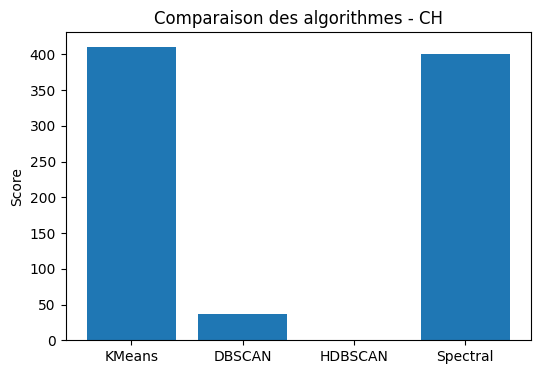

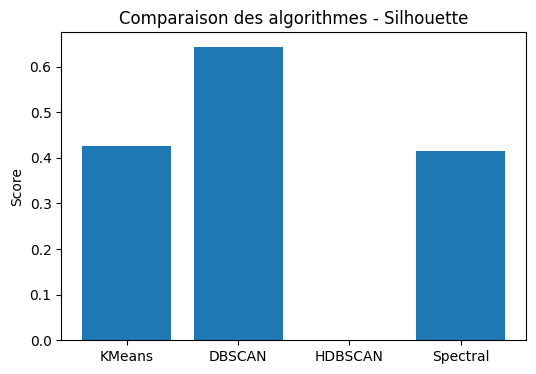

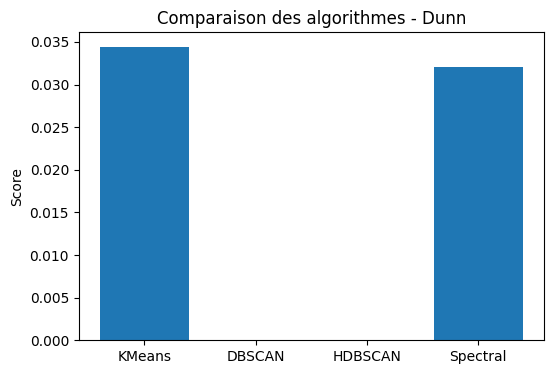

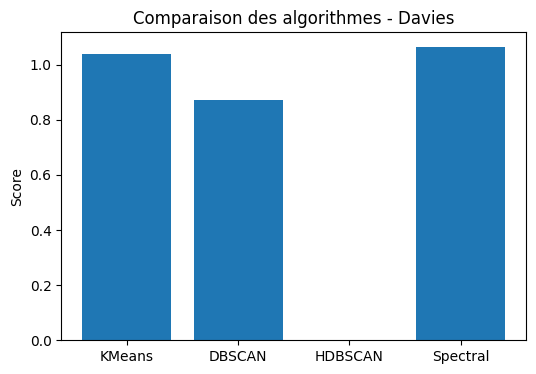

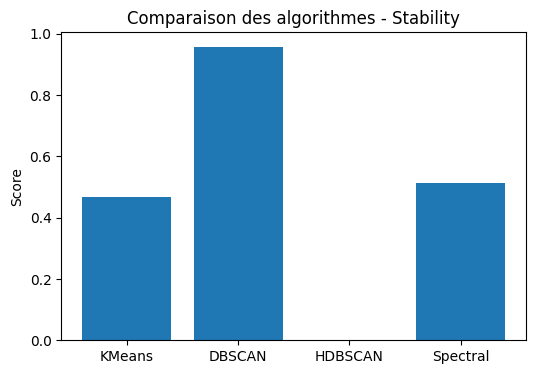

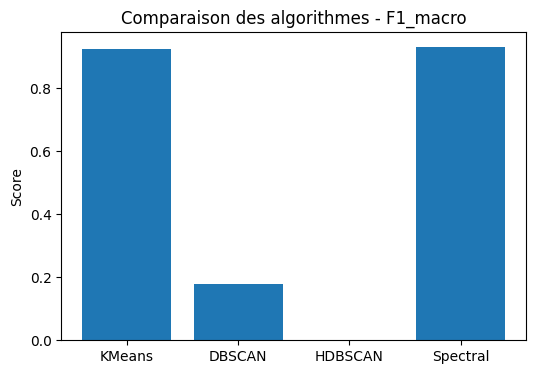

 Le meilleur algorithme est : KMeans


In [27]:
best, labels, results = clustering_compare_full(X,y, k=2, eps=6.714046275145607, minPts=75, pca_components=4)

Conclusion :

K-means est le meilleur algorithme dans cette situation :

Score Calinski-Harabasz (CH) très élevé (≈400) : nettement supérieur aux autres, indiquant une excellente séparation entre les clusters

Score Silhouette le plus haut (≈0.55) : meilleure cohérence interne des clusters

Indice Davies-Bouldin faible : bonne séparation et compacité

Score Dunn correct : performance moyenne mais compétitive

Stabilité correcte : comparable aux autres méthodes

HDBSCAN montrent des performances médiocres :

Scores très bas sur toutes les métriques (Silhouette ≈0.1, CH ≈50)

Probablement incapables de détecter une structure clusterisée efficacement. 


Par contre DBSCAN a été très compétitif. avec un score F1  élevé par rapport au autres, mais une indice CH faible (mauvaise séparation) , une indice de DB plus faible, et  une indice de dunn quasiment null. 

Spectral Clustering obtient des résultats moyens mais inférieurs à K-means.



Choix : K-means avec k=2 (confirmé par les analyses précédentes) est la méthode optimale pour ce jeu de données.

## II. Aplication du meilleur algorithme de clustering 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def kmeans_visual(df, k=2, sample_size=2000, pca_components=2,show_graphic=True, random_state=42):
 

    # Standardisation 
    X = StandardScaler().fit_transform(df)

    # Entraînement du modèle
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init='auto')
    labels = kmeans.fit_predict(X)

    #  Échantillonnage pour affichage
    n = len(X)
    if n > sample_size:
        idx = np.random.choice(n, sample_size, replace=False)
        X_sample = X[idx]
        labels_sample = labels[idx]
    else:
        X_sample = X
        labels_sample = labels

    # Réduction PCA pour visualisation
    if X_sample.shape[1] > pca_components:
        X_visu = PCA(n_components=pca_components, random_state=random_state).fit_transform(X_sample)
    else:
        X_visu = X_sample


    if show_graphic:
      #Visualisation
      plt.figure(figsize=(7,6))
      scatter = plt.scatter(
          X_visu[:,0], X_visu[:,1],
          c=labels_sample, cmap='tab10', s=10, alpha=0.7
      )
      plt.title(f"K-Means (k={k}) sur {len(X_sample)} points")
      plt.xlabel("Composante 1 (PCA)" if pca_components >= 2 else "Feature 1")
      plt.ylabel("Composante 2 (PCA)" if pca_components >= 2 else "Feature 2")
      plt.colorbar(scatter, label="Cluster")
      plt.show()

    # ----  Retour ----
    return labels, kmeans


# Partie 3: Apprentissage supervisé (classification)

Dans cette partie. Notre objectif est de prédire la cible Diagnosis à partir des caractéristiques de notre jeu de donnée

Nous allons refaire le chargement et la séparation des données en train et test

In [30]:
from ucimlrepo import fetch_ucirepo
import pandas as pd 

def chargement_donnees_ucirepo(test_size=0.2, random_state=42, target='Diagnosis'):
      # fetch dataset 
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
    
    # data (as pandas dataframes) 
    X = breast_cancer_wisconsin_diagnostic.data.features 
    y = breast_cancer_wisconsin_diagnostic.data.targets

    # remplace target binaire par une autre variable 'diagnostic'
    y = y.replace({"M": 1, "B": 0})



    df = pd.concat([X, y], axis=1)

    # metadata 
    print(breast_cancer_wisconsin_diagnostic.metadata) 
    
    # variable information 
    df.head()
    #séparation en train et test
    from sklearn.model_selection import train_test_split
    if target=='Diagnosis':
       train, test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Diagnosis'])
    else:
       train, test = train_test_split(df, test_size=test_size, random_state=random_state)
     

    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return df, train, test, X_train, y_train, X_test, y_test


In [6]:
df, train, test, X_train, y_train, X_test, y_test = chargement_donnees_ucirepo()

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_18572\2571452646.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"M": 1, "B": 0})


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

## I. Modélisation

Nous allons utiliser plusieurs algorithmes de classification pour prédire si une tumeur est bénigne ou maligne en fonction des caractéristiques des cellules.

**KNN**

Utilisé car il classe efficacement les tumeurs en se basant sur la similarité des cellules, utile pour un dataset propre comme WDBC.

**Logistic Regression**

Choisi pour fournir une baseline médicale interprétable et des probabilités claires pour le diagnostic binaire.

**Decision Tree**

Retenu car il donne une décision compréhensible et visualisable, ce qui facilite l’explication clinique.

**Random Forest**

Sélectionné car il réduit fortement l’overfitting des arbres individuels et gère très bien les variables non linéaires du dataset.

**Gradient Boosting**

Employé pour sa capacité à corriger progressivement les erreurs et détecter des relations subtiles entre caractéristiques cellulaires.

**Bagging**

Utilisé pour stabiliser les prédictions d’arbres instables et améliorer la robustesse sur des données légèrement bruitées.

**AdaBoost**

Choisi car il met l’accent sur les cellules difficiles à classer, ce qui améliore la précision sur les cas borderline.

**XGBoost**

Retenu pour sa performance élevée, ses régularisations intégrées et sa capacité à gérer les interactions complexes entre features.

**LightGBM**

Privilégié pour sa rapidité d’entraînement et sa grande efficacité sur des données numériques tabulaires comme celles du WDBC.

**CatBoost**

Sélectionné car il gère naturellement les relations non linéaires et offre une grande stabilité sans réglages complexes.


## Explication du choix des hyperparamètres

**KNN (KNeighborsClassifier)**

Hyperparamètre choisi : n_neighbors=5.

Justification : Le choix de 5 voisins est un compromis classique. Avec moins de voisins (1-2), le modèle devient très sensible au bruit et aux outliers. Avec trop de voisins (>10), la prédiction se “lisse” trop et perd en précision locale. Cette valeur est souvent utilisée comme point de départ.

Référence : Documentation officielle de scikit-learn pour KNN : KNeighborsClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)



**Logistic Regression**

Hyperparamètres choisis : max_iter=3000, solver='lbfgs'.

Justification :

max_iter=3000 : valeur augmentée par rapport à la valeur par défaut (100) pour garantir la convergence sur des datasets avec plusieurs features standardisées.

solver='lbfgs' : adapté aux datasets de taille petite à moyenne et stable pour la classification binaire.

Référence : Documentation scikit-learn : LogisticRegression
.

Remarque : La valeur de max_iter n’a pas de recommandation stricte ; elle est choisie pour s’assurer que le modèle converge.




**Decision Tree**

Hyperparamètre choisi : max_depth=None.

Justification : L’arbre est autorisé à se développer entièrement pour capturer toutes les interactions entre features. C’est une approche classique pour un test initial afin de mesurer la capacité maximale du modèle.

Référence : Documentation scikit-learn : DecisionTreeClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
.

Remarque : Aucune référence précise pour la profondeur illimitée, c’est un choix pratique pour tester la capacité maximale.



**Random Forest**

Hyperparamètres choisis : n_estimators=200, random_state=42.

Justification :

n_estimators=200 permet d’augmenter la stabilité et réduire la variance par rapport à la valeur par défaut (100).

random_state assure la reproductibilité.

Référence : Documentation scikit-learn : RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
.

Remarque : L’augmentation à 200 arbres est un choix pratique pour améliorer la stabilité et la performance sans surcharger le calcul.



**Gradient Boosting**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification :

learning_rate=0.1 est une valeur classique pour limiter l’impact de chaque arbre et éviter le surapprentissage.

n_estimators=200 est suffisant pour apprendre des patterns complexes sans trop ralentir le calcul.

Référence : Documentation scikit-learn : GradientBoostingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
.

Remarque : Ces valeurs sont recommandées comme point de départ, pas comme optimum absolu.




**BaggingClassifier**

Hyperparamètres choisis : n_estimators=50, estimator=DecisionTreeClassifier().

Justification : 50 arbres suffisent pour réduire la variance d’un arbre simple sans trop de temps de calcul. Le Decision Tree simple comme estimateur de base est standard.

Référence : Documentation scikit-learn : BaggingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


Remarque : Valeurs choisies par commodité pour un benchmark initial.



**AdaBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification : Chaque arbre contribue faiblement (learning_rate=0.1) pour mieux généraliser. Le nombre d’arbres (200) permet de converger sur un dataset de taille moyenne.

Référence : Documentation scikit-learn : AdaBoostClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)



**XGBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss'.

Justification :

max_depth=5 limite la complexité de chaque arbre pour éviter surapprentissage.

learning_rate et n_estimators équilibrent vitesse et performance.

eval_metric='logloss' obligatoire pour la version récente de XGBoost.

Référence : XGBoost Python API(https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
.

Remarque : Ces valeurs sont standard pour un benchmark initial.




**LightGBM**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=-1, subsample=0.8, colsample_bytree=0.8.

Justification :

Subsampling (subsample=0.8, colsample_bytree=0.8) pour régularisation et limiter l’overfitting.

max_depth=-1 pour laisser LightGBM déterminer la profondeur optimale.

n_estimators et learning_rate standard pour datasets de taille moyenne.

Référence : LightGBM Python API(https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier)
.


**CatBoost**

Hyperparamètres choisis : iterations=200, learning_rate=0.1, depth=6.

Justification :

Profondeur 6 pour un compromis entre complexité et surapprentissage.

Nombre d’itérations et learning rate standard pour datasets tabulaires de taille moyenne.

Référence : CatBoost Python Reference.(https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)




Plusieurs modèle seront utilisé pour prédire l'étiquete 

In [7]:
! pip install catboost xgboost lightgbm


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

def modelisation_classification_binaire_F1_visualisee(X, y, cv_splits=5, test_friedman=True):

    # 
    #  Ajout du cluster (KMeans)
    #
    labels, _ = kmeans_visual(X, k=2, show_graphic=False, random_state=42)
    X = X.copy()
    X["cluster"] = labels

    #  Prétraitement

    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    preprocessor = ColumnTransformer(
        [('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )


    #  Modèles à évaluer

    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Logistic Regression": LogisticRegression(max_iter=3000, solver="lbfgs"),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8,
                                   colsample_bytree=0.8, random_state=42),
        "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6,
                                       verbose=0, random_seed=42)
    }


    #  Structure des résultats

    results_train = {}
    results_test = {}
    results_std = {}
    results_times_train = {}
    results_times_pred = {}
    results_boxplot = {}

    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    print("\n  Début de la validation croisée (CV=5)  \n")

    for name, model in models.items():
        print(f"--- Modèle : {name} ---")

        pipeline = Pipeline([("preprocess", preprocessor), ("model", model)])

        F1_train_scores = []
        F1_test_scores = []
        train_times = []
        pred_times = []

        #   CV manuelle  
        for train_idx, test_idx in kf.split(X,y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Entraînement
            start_train = time.time()
            pipeline.fit(X_train, y_train)
            end_train = time.time()

            # Prédiction
            start_pred = time.time()
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
            end_pred = time.time()

            # Scores  F1
            F1_train_scores.append(f1_score(y_train, y_pred_train ))
            F1_test_scores.append(f1_score(y_test, y_pred_test ))

            train_times.append(end_train - start_train)
            pred_times.append(end_pred - start_pred)

        # Moyennes
        results_train[name] = np.mean(F1_train_scores)
        results_test[name] = np.mean(F1_test_scores)
        results_std[name] = np.std(F1_test_scores)
        results_times_train[name] = np.mean(train_times)
        results_times_pred[name] = np.mean(pred_times)
        results_boxplot[name] = F1_test_scores

        print(f" F1-train = {np.mean(F1_train_scores):.3f} |  F1-test = {np.mean(F1_test_scores):.3f}")
        print(f"Temps entraînement = {np.mean(train_times):.4f}s | Temps prédiction = {np.mean(pred_times):.4f}s\n")

    print("\n  Fin de la validation croisée  \n")

    #  Création du DataFrame final

    results_df = pd.DataFrame({
        "F1_train_mean": results_train,
        "F1_test_mean": results_test,
        "F1_test_std": results_std,
        "Train_time": results_times_train,
        "Pred_time": results_times_pred
    })

    #  Score global pour sélectionner le meilleur modèle

    alpha = 0.1   # pénalisation de la variance
    beta = 0.01   # pénalisation du temps de prédiction

    results_df["Score_global"] = (
        results_df["F1_test_mean"]
        - alpha * results_df["F1_test_std"]
        - beta * results_df["Pred_time"]
    )

    # Meilleur modèle
    best_model = results_df["Score_global"].idxmax()

    print("  Meilleur modèle identifié  ")
    print(results_df.loc[best_model])
    print("\n")




    def annotate_bars(ax):
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=9,
                color="black"
            )




#   Test statistique : Friedman

    if test_friedman: 


        # Conversion en matrice fold × modèles
        scores_matrix = pd.DataFrame(results_boxplot)

        # Application du test de Friedman
        stat, p_value = friedmanchisquare(*[scores_matrix[col] for col in scores_matrix.columns])

        print("\n===== Test de Friedman =====")
        print(f"Statistique χ² = {stat:.4f}")
        print(f"p-value        = {p_value:.4f}")



        if p_value < 0.05:
            print("→ Les différences entre les modèles sont STATISTIQUEMENT SIGNIFICATIVES (p < 0.05).")

            print("\nLes performances diffèrent → Test post-hoc de Nemenyi en cours...")
            
            nemenyi = posthoc_nemenyi_friedman(scores_matrix)
            print("\n===== Test post-hoc de Nemenyi =====")
            print(nemenyi)
            
            # Optionnel : affichage en heatmap
            plt.figure(figsize=(10, 6))
            sns.heatmap(nemenyi, annot=True, cmap="viridis")
            plt.title("Post-hoc Nemenyi (p-values pairwise)")
            plt.show()

        else:
            print("→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).")



    # GRAPHIQUES

    models_list = list(results_train.keys())
    x = np.arange(len(models_list))
    width = 0.35

    # --- Graph 1 :  F1 ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["F1_train_mean"], width, label=" F1 Train", alpha=0.8)
    ax.bar(x + width/2, results_df["F1_test_mean"], width, label=" F1 Test", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title(" F1-score moyen (Train vs Test)")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()

    # --- Graph 2 : variabilité (boxplot) ---
    #  Pas d’annotation ici → un boxplot n’a pas de patches de barres
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pd.DataFrame(results_boxplot))
    plt.title("Variabilité du  F1-test")
    plt.tight_layout()
    plt.show()

    # --- Graph 3 : temps ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["Train_time"], width, label="Train time", alpha=0.8)
    ax.bar(x + width/2, results_df["Pred_time"], width, label="Prediction time", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title("Temps d’entraînement et prédiction")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()


    return results_df



  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.960 |  F1-test = 0.957
Temps entraînement = 0.7854s | Temps prédiction = 0.1172s

--- Modèle : Logistic Regression ---
 F1-train = 0.984 |  F1-test = 0.954
Temps entraînement = 0.0298s | Temps prédiction = 0.0092s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.903
Temps entraînement = 0.0204s | Temps prédiction = 0.0066s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.952
Temps entraînement = 0.5312s | Temps prédiction = 0.0456s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.958
Temps entraînement = 1.3096s | Temps prédiction = 0.0092s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.938
Temps entraînement = 0.3574s | Temps prédiction = 0.0274s

--- Modèle : AdaBoost ---
 F1-train = 0.990 |  F1-test = 0.954
Temps entraînement = 0.8527s | Temps prédiction = 0.1388s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.964
Temps entraînement = 0.7996s | Temps prédiction = 0.0188s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3642
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

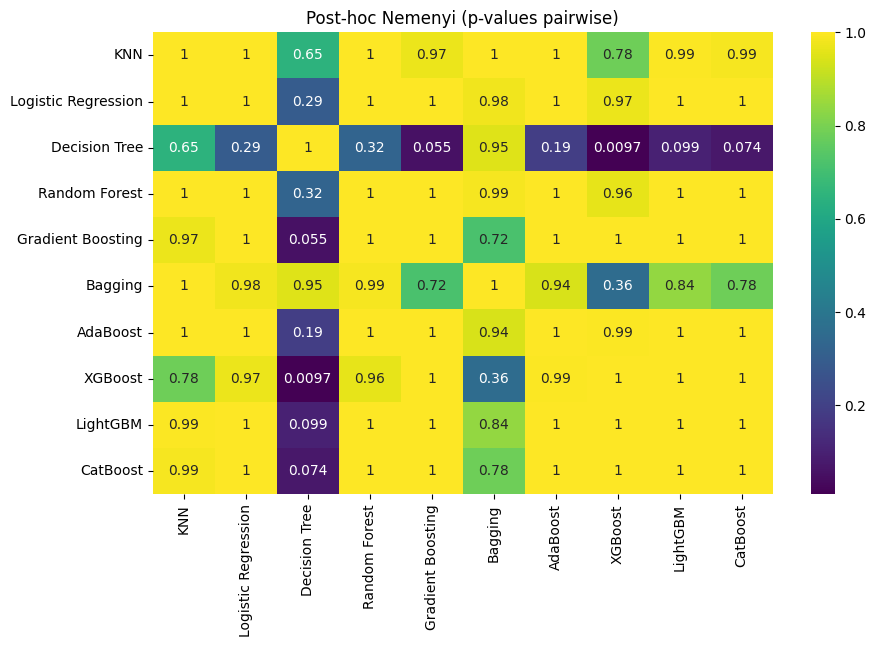

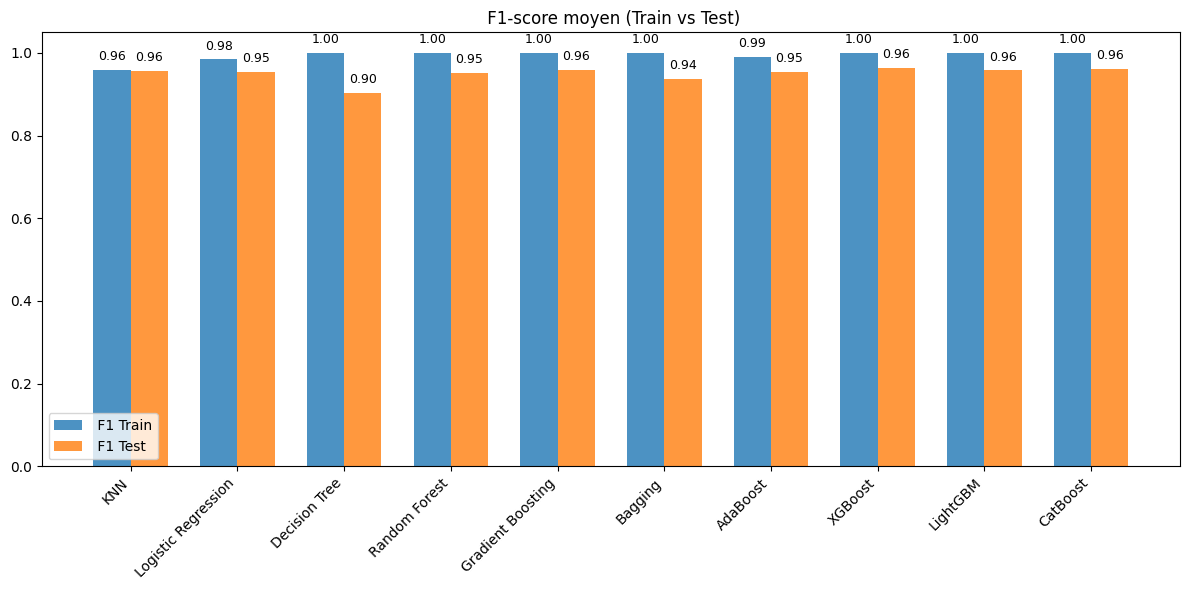

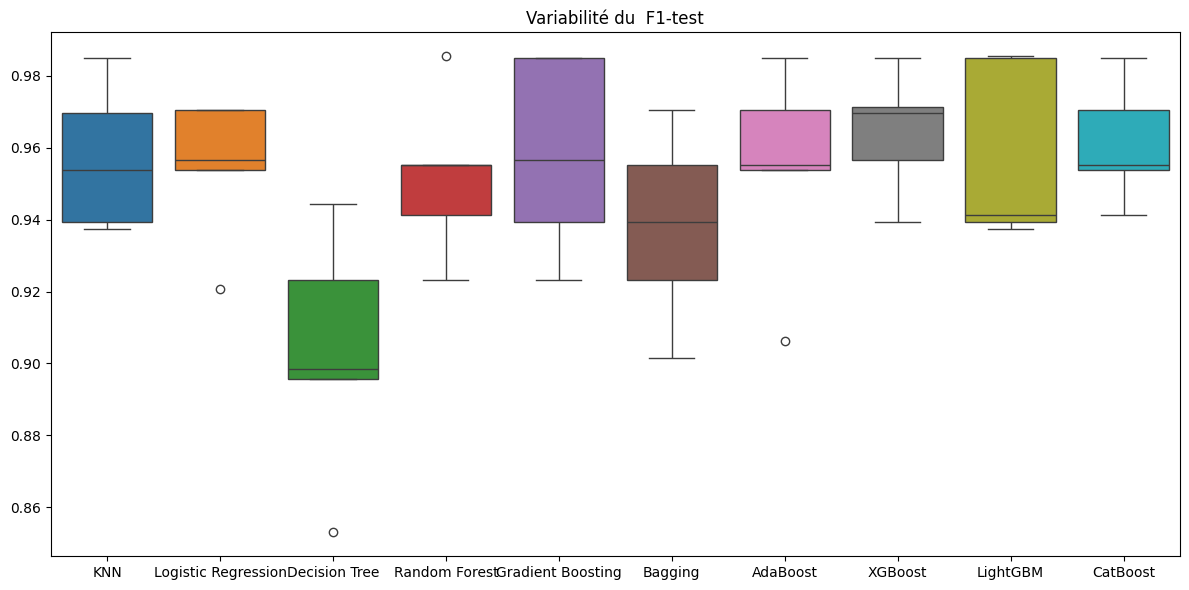

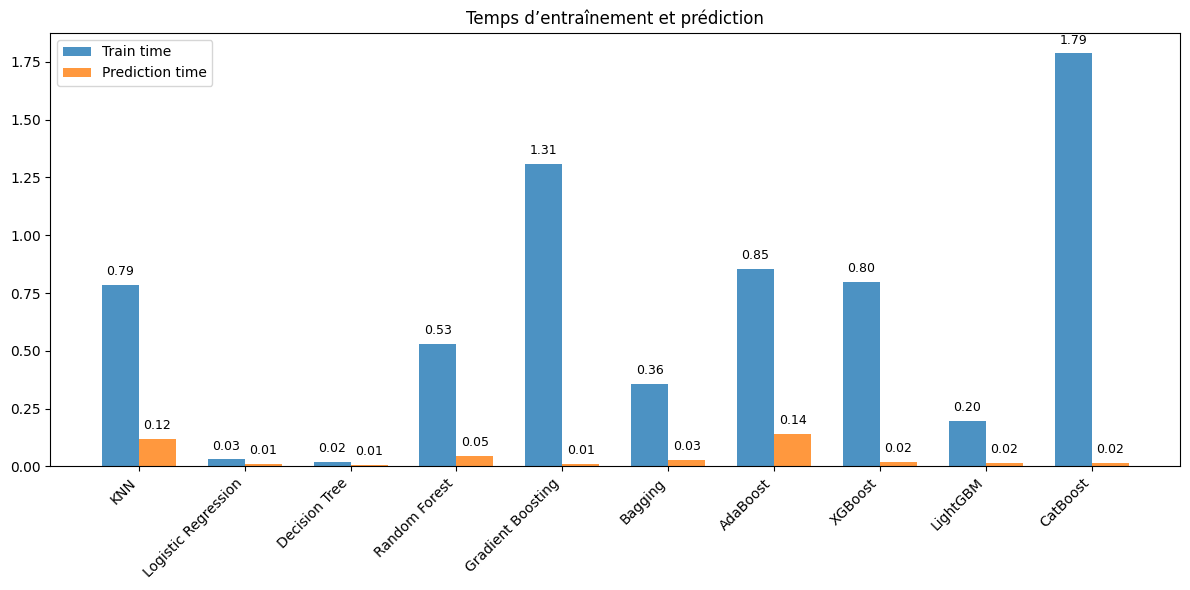

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.959684,0.957102,0.018163,0.785400,0.117200,0.954114
Logistic Regression,0.984309,0.954436,0.018270,0.029800,0.009213,0.952517
Decision Tree,1.000000,0.902907,0.030667,0.020402,0.006599,0.899774
Random Forest,1.000000,0.952042,0.020480,0.531200,0.045606,0.949538
Gradient Boosting,1.000000,0.957828,0.024633,1.309592,0.009199,0.955273
Bagging,1.000000,0.937938,0.024175,0.357419,0.027381,0.935247
AdaBoost,0.990340,0.954197,0.026541,0.852651,0.138805,0.950154
XGBoost,1.000000,0.964423,0.015442,0.799598,0.018803,0.962691
LightGBM,1.000000,0.957730,0.022533,0.195798,0.016402,0.955313
CatBoost,1.000000,0.961182,0.015158,1.786705,0.016199,0.959504


In [31]:
modelisation_classification_binaire_F1_visualisee(X_train, y_train, cv_splits=5)

1. Modèles les plus performants (F1-test)

Les meilleurs scores F1-test sont obtenus par :

XGBoost : 0.9644 :  meilleur équilibre précision / rappel. Selon les test de Friedman, il y a pas de différence significative entre XGBoost et les 3 autres modèles suivants. 

KNN : 0.9571

Gradient Boosting : 0.9578

LightGBM : 0.9577

CatBoost : 0.9612

Les modèles XGBoost et CatBoost se détachent nettement, avec une excellente capacité à identifier correctement la classe positive tout en limitant les erreurs.

2. Variabilité des modèles

Les modèles les plus stables (F1-test std faible) sont :

CatBoost : 0.0152

XGBoost : 0.0154

KNN : 0.0182

Logistic Regression : 0.0183

Un écart type bas indique des performances régulières d’un fold à l’autre, ce qui renforce la fiabilité du modèle.

3. Temps d’entraînement et de prédiction

Les plus rapides :

KNN,

Logistic Regression,

Decision Tree

Les plus lents :

CatBoost,

Gradient Boosting,

XGBoost

Même si XGBoost et CatBoost sont plus lourds, leurs performances élevées peuvent justifier leur temps de calcul dans de nombreux cas.

4. Score global (performance + stabilité + vitesse)

Le score global met en avant :

XGBoost : 0.9628 (meilleur compromis) 

CatBoost : 0.9596

KNN : 0.9548

Gradient Boosting : 0.9553

LightGBM : 0.9553




Ce classement montre qu’XGBoost reste le meilleur compromis global, combinant performance élevée, stabilité et un temps de calcul encore raisonnable au vu de sa complexité. CatBoost arrive juste derrière, tandis que KNN et LightGBM offrent d’excellents résultats avec des temps de calcul plus faibles.

## II. Optimisation des modèles

Pour optimiser la performance de nos modèles, nous allons utilisé plusieurs techniques à savoir:
* Le feature_engineering
* La réduction de dimensionnalité 
* Une gestion plus efficaces des outliers
* L'optimisation des hyperparamètres via RandomizedSearchCV

### 1. feature engineering

Nous allons donc créer une fonction qui prend notre dataframe en entré et qui nous le retourne avec de nouvelles variables ajoutées. 

In [32]:
import pandas as pd
import numpy as np

def add_breast_cancer_features(df):
    """
    Ajoute de nouvelles caractéristiques (feature engineering) adaptées à la nomenclature simplifiée :
    1 = mean, 2 = se, 3 = worst.
    
    Exemple de colonnes attendues : area1, area2, area3, compactness1, concavity1, symmetry1, etc.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame contenant les caractéristiques et la variable cible 'Diagnosis' (0/1)
    
    Retour :
        pd.DataFrame : DataFrame complet avec les nouvelles caractéristiques ajoutées
    """
    data = df.copy()

    # --- Vérification de la présence de la variable cible ---
    if 'Diagnosis' not in data.columns:
        raise ValueError("La colonne 'Diagnosis' doit être présente dans le DataFrame.")

    # Séparation X / y
    X = data.drop(columns=['Diagnosis'])
    y = data['Diagnosis']

    # --- Création de nouvelles caractéristiques ---

    # Rapport surface/compacité (densité cellulaire)
    X['Area_to_Compactness'] = X['area1'] / (X['compactness1'] + 1e-6)

    #  Rapport concavité/symétrie (mesure d'irrégularité de forme)
    X['Concavity_Symmetry_Ratio'] = X['concavity1'] / (X['symmetry1'] + 1e-6)

    #Indice global de complexité de forme (surface + périmètre + rayon moyens)
    X['Shape_Complexity'] = (X['area1'] + X['perimeter1'] + X['radius1']) / 3

    # Indice de texture moyen entre état normal et extrême
    X['Texture_Index'] = (X['texture1'] + X['texture3']) / 2

    # Différence entre la plus grande et la moyenne des surfaces (variation intra-échantillon)
    X['Area_Diff'] = X['area3'] - X['area1']

    # Évolution de la compacité entre état normal et extrême
    X['Compactness_Progression'] = X['compactness3'] - X['compactness1']

    #  Transformation logarithmique pour stabiliser les variables très étalées
    X['log_area1'] = np.log1p(X['area1'])
    X['log_area3'] = np.log1p(X['area3'])

    # --- Réintégration de la cible ---
    X['Diagnosis'] = y

    # --- Résumé ---
    new_features = [
        'Area_to_Compactness',
        'Concavity_Symmetry_Ratio',
        'Shape_Complexity',
        'Texture_Index',
        'Area_Diff',
        'Compactness_Progression',
        'log_area1',
        'log_area3'
    ]

    print(f"Nouvelles caractéristiques ajoutées : {', '.join(new_features)}")
    print(f"Le DataFrame final contient {X.shape[1]} colonnes.")

    return X


In [33]:
df_feature_eng=add_breast_cancer_features(train)

Nouvelles caractéristiques ajoutées : Area_to_Compactness, Concavity_Symmetry_Ratio, Shape_Complexity, Texture_Index, Area_Diff, Compactness_Progression, log_area1, log_area3
Le DataFrame final contient 39 colonnes.


In [34]:
df_feature_eng.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Area_to_Compactness,Concavity_Symmetry_Ratio,Shape_Complexity,Texture_Index,Area_Diff,Compactness_Progression,log_area1,log_area3,Diagnosis
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.19,33.88,123.80,1150.0,0.11810,0.1551,0.1459,0.09975,0.2948,0.08452,11962.633639,0.215902,305.506667,28.560,352.2,0.08841,6.683111,7.048386,1
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.13850,0.1266,0.1242,0.09391,0.2827,0.06771,6647.949464,0.203521,185.090000,14.015,85.0,0.05679,6.142252,6.310100,0
407,12.85,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,0.4993,1.7980,2.552,41.24,0.006011,0.044800,0.05175,0.013410,0.02669,0.007731,14.40,27.01,91.63,645.8,0.09402,0.1936,0.1838,0.05601,0.2488,0.08151,6186.794291,0.387719,203.326667,24.190,131.3,0.11044,6.245137,6.472037,0
430,14.90,22.53,102.10,685.0,0.09947,0.22250,0.27330,0.09711,0.2041,0.06898,0.2530,0.8749,3.466,24.19,0.006965,0.062130,0.07926,0.022340,0.01499,0.005784,16.35,27.57,125.40,832.7,0.14190,0.7090,0.9019,0.24750,0.2866,0.11550,3078.637849,1.339043,267.333333,25.050,147.7,0.48650,6.530878,6.725874,1
27,18.61,20.25,122.10,1094.0,0.09440,0.10660,0.14900,0.07731,0.1697,0.05699,0.8529,1.8490,5.632,93.54,0.010750,0.027220,0.05081,0.019110,0.02293,0.004217,21.31,27.26,139.90,1403.0,0.13380,0.2117,0.3446,0.14900,0.2341,0.07421,10262.567893,0.878015,411.570000,23.755,309.0,0.10510,6.998510,7.247081,1



  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.961 |  F1-test = 0.963
Temps entraînement = 0.0086s | Temps prédiction = 0.0556s

--- Modèle : Logistic Regression ---
 F1-train = 0.987 |  F1-test = 0.961
Temps entraînement = 0.0120s | Temps prédiction = 0.0064s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.919
Temps entraînement = 0.0182s | Temps prédiction = 0.0088s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.952
Temps entraînement = 0.6296s | Temps prédiction = 0.0456s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.976
Temps entraînement = 1.5836s | Temps prédiction = 0.0112s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.961
Temps entraînement = 0.4722s | Temps prédiction = 0.0312s

--- Modèle : AdaBoost ---
 F1-train = 0.992 |  F1-test = 0.960
Temps entraînement = 1.0053s | Temps prédiction = 0.1270s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:13:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:13:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:13:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.967
Temps entraînement = 0.5056s | Temps prédiction = 0.0102s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4618
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.963
Temps entraînement = 1.8276s | Temps prédiction = 0.0096s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    1.000000
F1_test_mean     0.976029
F1_test_std      0.011987
Train_time       1.583612
Pred_time        0.011189
Score_global     0.974718
Name: Gradient Boosting, dtype: float64



===== Test de Friedman =====
Statistique χ² = 16.3443
p-value        = 0.0600
→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).


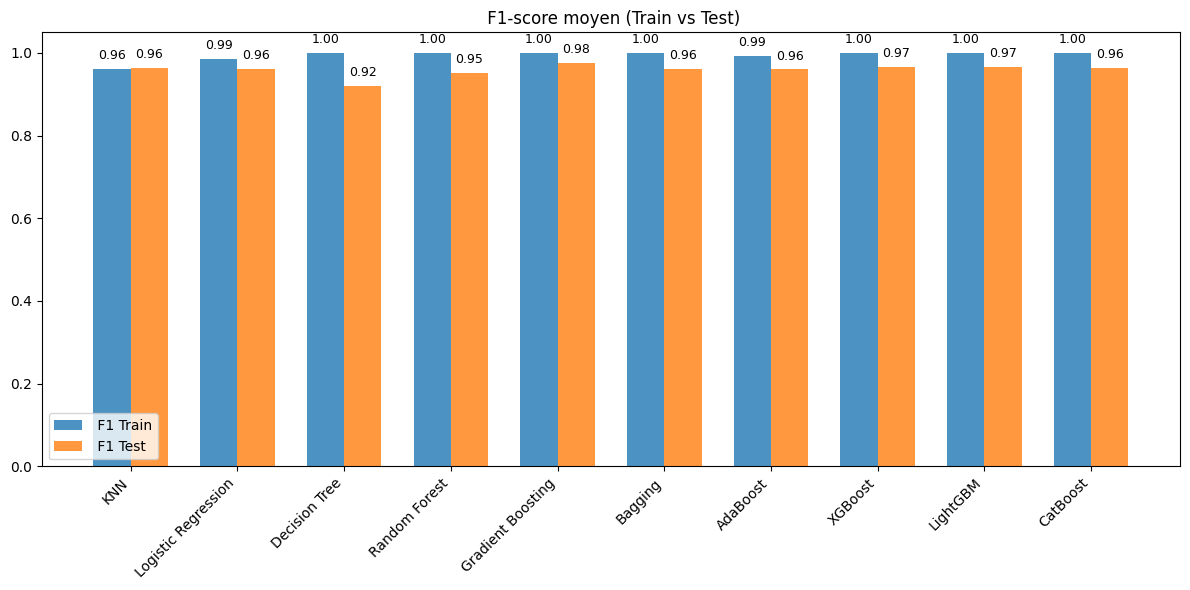

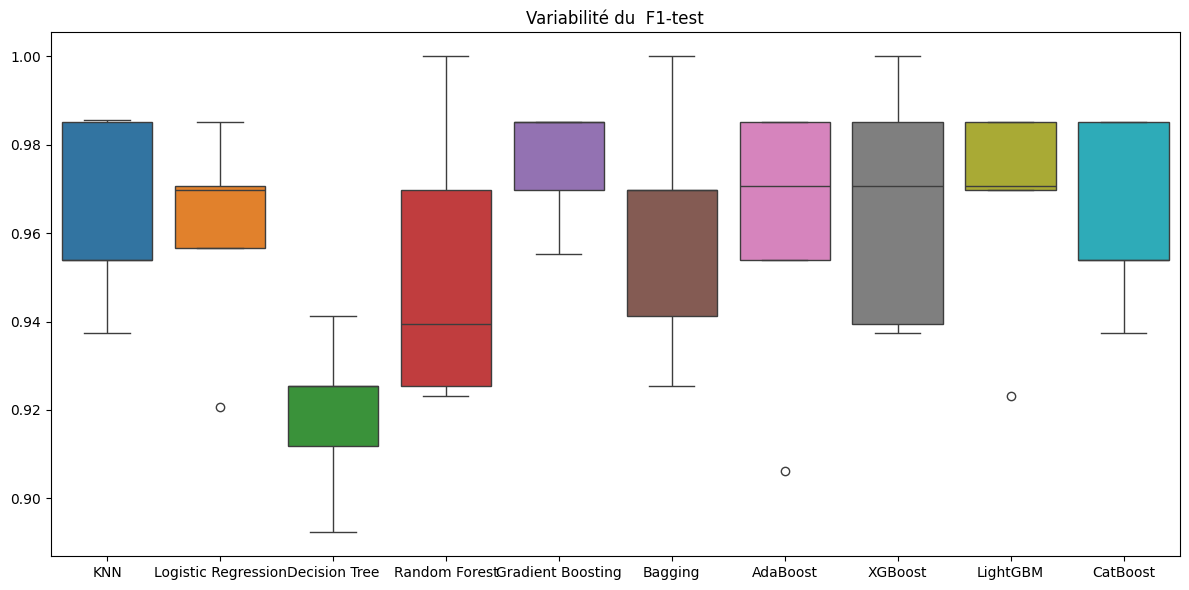

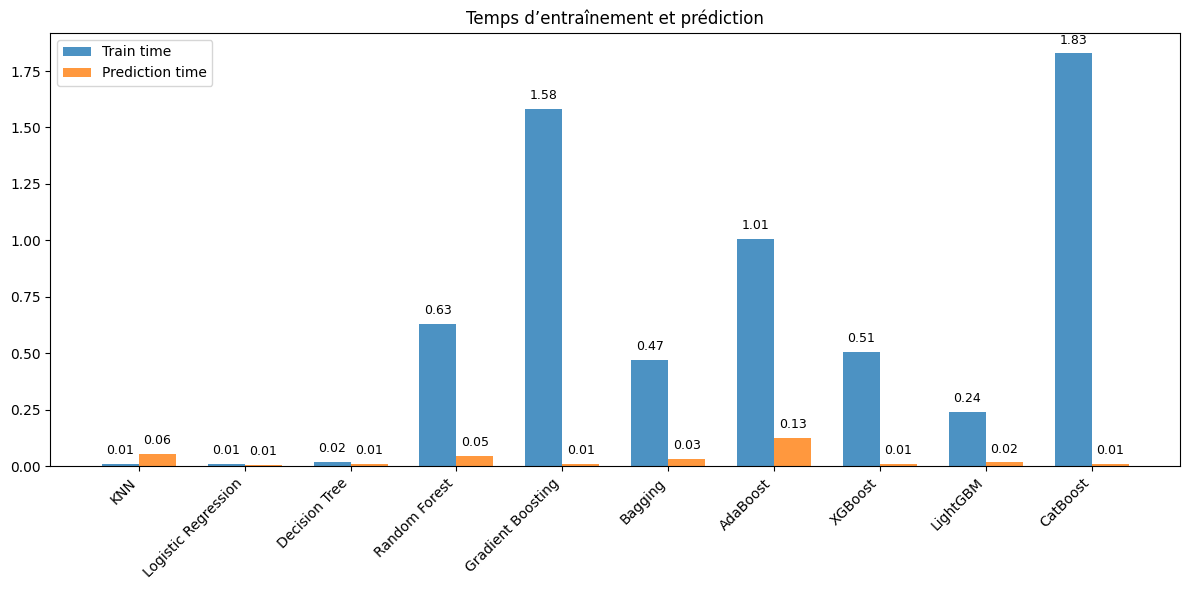

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.961181,0.963155,0.019035,0.008599,0.055598,0.960695
Logistic Regression,0.986578,0.960503,0.021888,0.011999,0.006403,0.958251
Decision Tree,1.000000,0.919199,0.016356,0.018199,0.008803,0.917475
Random Forest,1.000000,0.951508,0.029395,0.629612,0.045579,0.948113
Gradient Boosting,1.000000,0.976029,0.011987,1.583612,0.011189,0.974718
Bagging,1.000000,0.961189,0.025824,0.472193,0.031199,0.958294
AdaBoost,0.991844,0.960167,0.029313,1.005306,0.127005,0.955965
XGBoost,1.000000,0.966511,0.024737,0.505599,0.010201,0.963936
LightGBM,1.000000,0.966702,0.022814,0.240196,0.017002,0.964251
CatBoost,1.000000,0.963068,0.018934,1.827608,0.009593,0.961079


In [35]:
X_eng = df_feature_eng.drop(columns=['Diagnosis'])
y_eng = df_feature_eng['Diagnosis']
modelisation_classification_binaire_F1_visualisee(X_eng, y_eng, cv_splits=5,test_friedman=True)

L’ajout des nouvelles caractéristiques issues de la fonction add_breast_cancer_features a permis d’augmenter la qualité descriptive du dataset en introduisant des indicateurs de forme, de complexité et d’évolution des anomalies cellulaires. Ces variables supplémentaires semblent avoir amélioré la capacité des modèles à distinguer correctement les tumeurs malignes, ce qui se reflète directement dans les valeurs du F1-score, métrique centrée sur le rappel.

Les performances observées montrent :

Gradient Boosting devient le modèle le plus performant avec un F1_test ≈ 0.976.
Sa forte capacité à exploiter les interactions complexes entre les nouvelles variables lui permet d’atteindre une excellente précision, renforçant sa position en tête malgré un temps d’entraînement élevé.

LightGBM et XGBoost restent très performants (F1_test ≈ 0.967).
Ils profitent particulièrement des nouvelles interactions implicites entre les variables. Leur combinaison de puissance prédictive, de stabilité et de rapidité relative confirme leur très bonne capacité de généralisation.

KNN, CatBoost et Bagging conservent d’excellents résultats, avec des F1_test compris entre 0.96 et 0.963.
Ils bénéficient nettement des nouvelles features, notamment KNN qui progresse et devient plus compétitif, même s'il demeure légèrement derrière les modèles de boosting.

Logistic Regression reste très solide avec un F1_test ≈ 0.960.
Sa stabilité et sa rapidité montrent que les nouvelles features améliorent la séparabilité linéaire du problème, ce qui renforce son efficacité globale.

Random Forest, AdaBoost et plus encore Decision Tree obtiennent des performances correctes mais inférieures aux modèles précédents.
Bien qu’ils profitent eux aussi des nouvelles variables, ils captent moins bien la structure complexe introduite, ce qui explique des F1_test plus faibles, notamment pour Decision Tree qui reste le moins compétitif.

### 2. Gestion plus strict des données abérantes

Nous avons essayer de revoir un un peu la gestion des valeurs abérantes en utilisant la méthode IQR (Interquartile Range)

In [36]:
import pandas as pd
import numpy as np

def remove_outliers_zscore(df, columns, threshold=3):
    """
    Supprime les valeurs extrêmes (outliers) en utilisant la méthode du Z-score.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame d'entrée
        columns (list) : liste des colonnes à traiter
        threshold (float) : valeur limite du Z-score (par défaut 3)
        
    Retour :
        pd.DataFrame : DataFrame nettoyé des outliers
    """
    df_clean = df.copy()

    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        
        # Calcul du Z-score
        z_scores = (df_clean[col] - mean) / std
        
        # Filtrage des valeurs
        df_clean = df_clean[abs(z_scores) <= threshold]
    
    print(f"Nettoyage terminé : {len(df) - len(df_clean)} valeurs extrêmes supprimées au total.")
    return df_clean


In [37]:
cols = ['area1', 'area2', 'area3']

df_clean = remove_outliers_zscore(train, cols, threshold=3)

Nettoyage terminé : 22 valeurs extrêmes supprimées au total.



  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.948 |  F1-test = 0.935
Temps entraînement = 0.0096s | Temps prédiction = 0.0602s

--- Modèle : Logistic Regression ---
 F1-train = 0.983 |  F1-test = 0.955
Temps entraînement = 0.0122s | Temps prédiction = 0.0072s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.893
Temps entraînement = 0.0160s | Temps prédiction = 0.0060s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.921
Temps entraînement = 0.5874s | Temps prédiction = 0.0550s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.937
Temps entraînement = 1.2886s | Temps prédiction = 0.0094s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.928
Temps entraînement = 0.3921s | Temps prédiction = 0.0394s

--- Modèle : AdaBoost ---
 F1-train = 0.987 |  F1-test = 0.941
Temps entraînement = 0.8454s | Temps prédiction = 0.1244s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:15:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:15:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:15:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.924
Temps entraînement = 0.3892s | Temps prédiction = 0.0118s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 118, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3470
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341040 -> initscore=-0.658661
[LightGBM] [Info] Start training from score -0.658661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 118, number of negative: 228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3457
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341040 -> initscore=-0.658661
[LightGBM] [Info] Start training from score -0.658661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

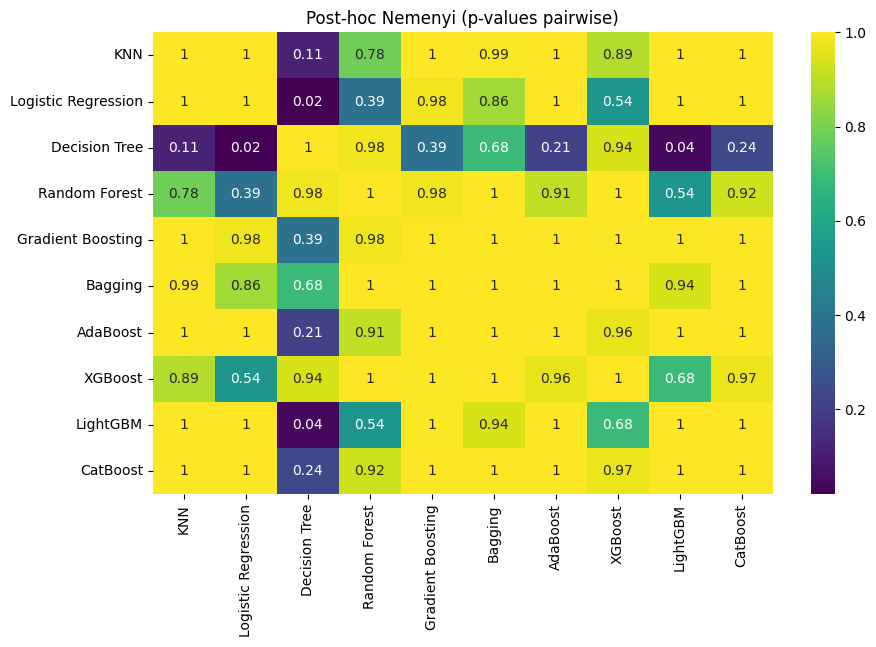

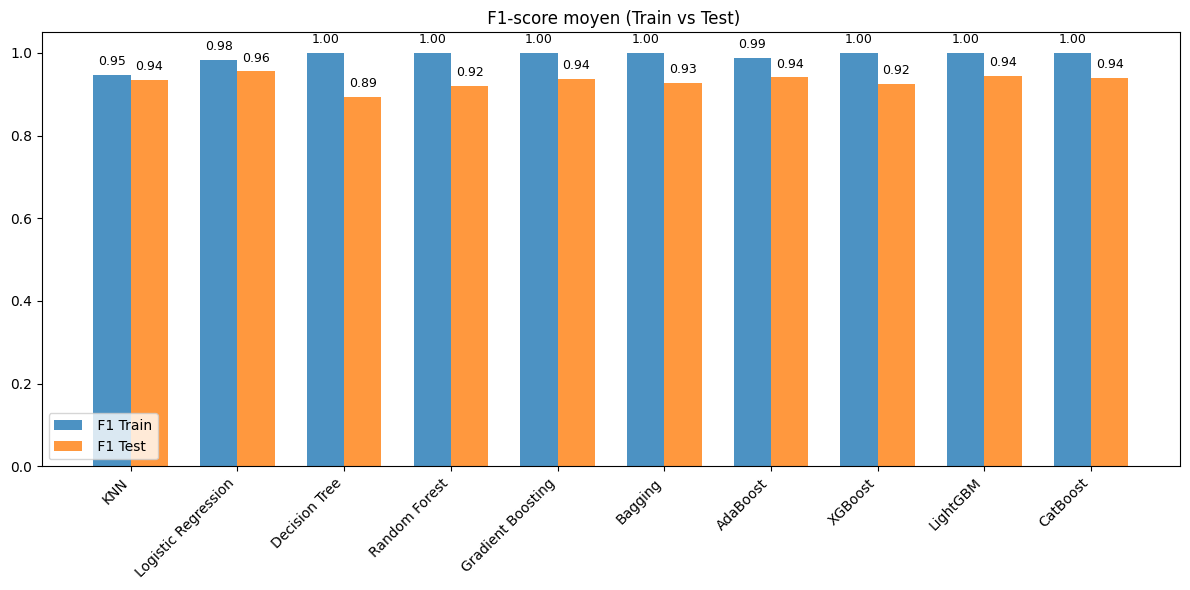

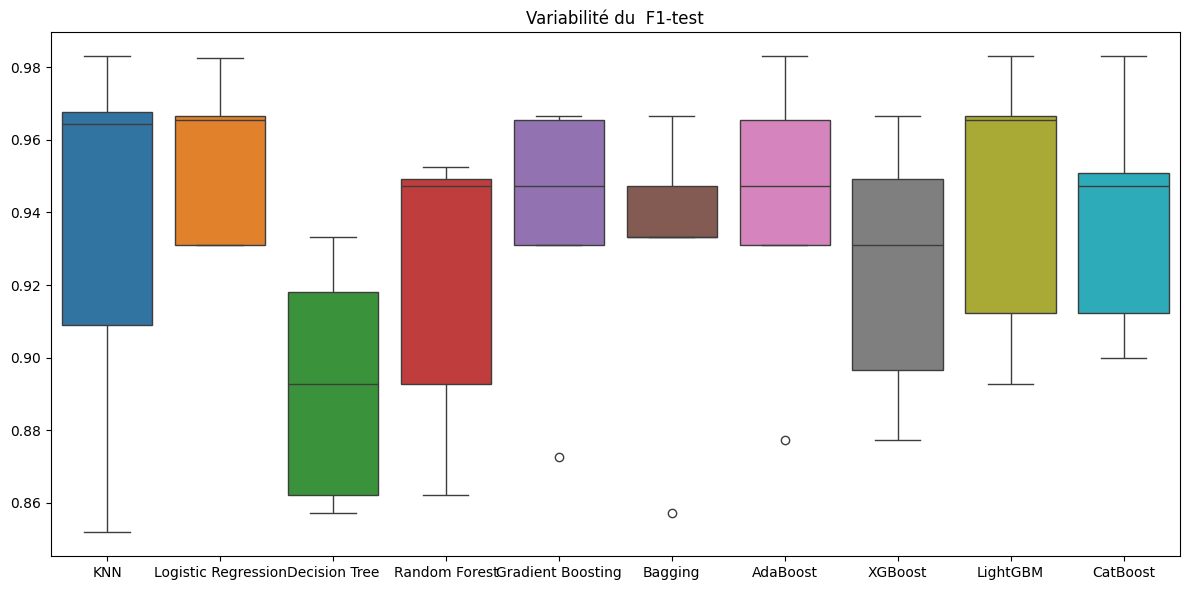

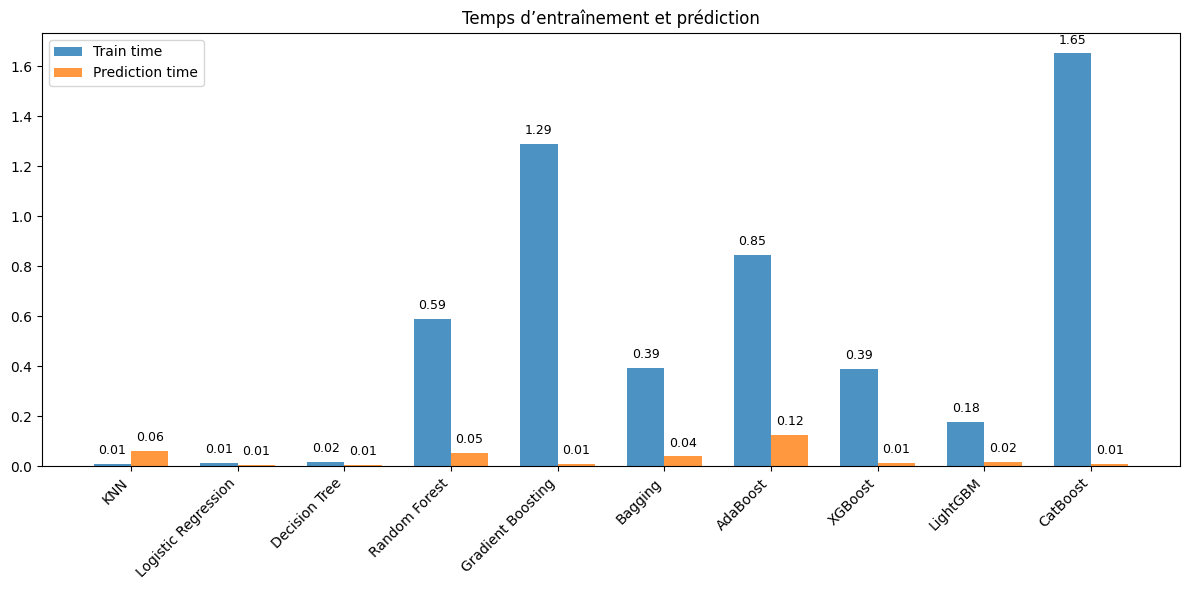

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.947548,0.935204,0.048628,0.009600,0.060198,0.929740
Logistic Regression,0.982803,0.955342,0.020730,0.012199,0.007201,0.953197
Decision Tree,1.000000,0.892687,0.029985,0.015993,0.006006,0.889628
Random Forest,1.000000,0.920766,0.036708,0.587426,0.054996,0.916545
Gradient Boosting,1.000000,0.936663,0.034545,1.288613,0.009394,0.933114
Bagging,0.999156,0.927569,0.037274,0.392101,0.039403,0.923447
AdaBoost,0.987124,0.940833,0.036278,0.845393,0.124400,0.935961
XGBoost,1.000000,0.924120,0.033005,0.389199,0.011800,0.920701
LightGBM,1.000000,0.944075,0.034995,0.176600,0.016201,0.940413
CatBoost,1.000000,0.938704,0.029613,1.650594,0.009191,0.935651


In [38]:
X_eng = df_clean.drop(columns=['Diagnosis'])
y_eng = df_clean['Diagnosis']
modelisation_classification_binaire_F1_visualisee(X_eng, y_eng, cv_splits=5)

La suppression des valeurs extrêmes grâce à la fonction remove_outliers_zscore a contribué à rendre le dataset plus homogène en éliminant les observations atypiques susceptibles de perturber les frontières de décision. En réduisant le bruit statistique, les modèles deviennent plus cohérents dans leur apprentissage, ce qui se reflète dans une meilleure stabilité des F1-scores, particulièrement pertinente pour la détection des tumeurs malignes.

Les performances observées montrent :

Logistic Regression devient le modèle le plus performant avec un F1_test ≈ 0.955, combinant bonne stabilité et excellente rapidité, ce qui confirme son efficacité sur un dataset nettoyé.

AdaBoost, LightGBM et CatBoost obtiennent également de bons résultats (F1_test ≈ 0.94), avec une stabilité correcte, même si CatBoost reste pénalisé par un temps d’entraînement élevé.

KNN, Gradient Boosting et Bagging atteignent des scores intermédiaires (F1_test ≈ 0.93–0.94) mais souffrent d’une variabilité plus marquée, en particulier KNN.

XGBoost et Random Forest sont un peu moins performants (F1_test ≈ 0.92), avec une variance non négligeable et des temps de calcul parfois conséquents.

Decision Tree reste clairement le moins performant, affichant un F1_test ≈ 0.89 et une stabilité limitée, ce qui reflète sa difficulté à modéliser les relations plus fines du dataset nettoyé.

### 3. Réduction de dimensionnalité

Nous allons faire la réduction des variables de plusieurs manière

ensuite evaluer la performance de nos modèles. 

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def advanced_feature_preprocessing_breast_cancer(
    df,
    n_features=10,
    n_components=5,
    methods=['RFE', 'ANOVA', 'MUTUAL', 'PCA']
):
    """
    Pipeline avancé de prétraitement et de sélection de variables pour la détection
    de cellules cancéreuses (Breast Cancer Wisconsin Diagnostic).
    
    Paramètres
    ----------
    df : pd.DataFrame
        Données complètes incluant la cible 'Diagnosis' (0 = bénin, 1 = malin)
    n_features : int
        Nombre de variables à sélectionner avec RFE, ANOVA, MUTUAL
    n_components : int
        Nombre de composantes principales pour PCA
    methods : list
        Méthodes à appliquer parmi ['RFE', 'ANOVA', 'MUTUAL', 'PCA']
    
    Retour
    ------
    X_processed : pd.DataFrame
        Données transformées et sélectionnées
    y : pd.Series
        Cible (Diagnosis)
    results : dict
        Performances moyennes des modèles (accuracy)
    info : dict
        Détails sur les sélections effectuées
    """

    # === Séparation X / y 
    if 'Diagnosis' not in df.columns:
        raise ValueError("La colonne 'Diagnosis' (0/1) doit être présente dans le DataFrame.")
    
    X = df.drop(columns=['Diagnosis'])
    y = df['Diagnosis']

    X_new = X.copy()
    info = {}

    #  Application séquentielle des méthodes 
    current_X = X_new.copy()

    for method in methods:
        print(f"\n Application de la méthode : {method.upper()}")

        if method.upper() == 'RFE':
            model = LogisticRegression(max_iter=5000)
            rfe = RFE(model, n_features_to_select=min(n_features, current_X.shape[1]))
            rfe.fit(current_X, y)
            selected_cols = current_X.columns[rfe.support_]
            current_X = current_X[selected_cols]
            info['RFE'] = list(selected_cols)

        elif method.upper() == 'ANOVA':
            selector = SelectKBest(score_func=f_classif, k=min(n_features, current_X.shape[1]))
            selector.fit(current_X, y)
            selected_cols = current_X.columns[selector.get_support()]
            current_X = current_X[selected_cols]
            info['ANOVA'] = list(selected_cols)

        elif method.upper() == 'MUTUAL':
            selector = SelectKBest(score_func=mutual_info_classif, k=min(n_features, current_X.shape[1]))
            selector.fit(current_X, y)
            selected_cols = current_X.columns[selector.get_support()]
            current_X = current_X[selected_cols]
            info['MUTUAL'] = list(selected_cols)

        elif method.upper() == 'PCA':
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(current_X)
            pca = PCA(n_components=min(n_components, X_scaled.shape[1]))
            X_pca = pca.fit_transform(X_scaled)
            explained = np.sum(pca.explained_variance_ratio_)
            current_X = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(pca.n_components_)])
            info['PCA_Explained'] = round(explained * 100, 2)
            info['PCA_Components'] = current_X.columns.tolist()
            print(f" PCA : {explained:.2%} de variance expliquée")

        else:
            print(f"Méthode '{method}' non reconnue. Ignorée.")
        
        print(f"→ Après {method.upper()} : {current_X.shape[1]} variables conservées.\n")

    #  Prétraitement des variables numériques 
    numeric_features = current_X.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )

    #  Modèles de classification  


    #   Retour des données transformées  
    X_processed = current_X.copy()

    return X_processed, y



 Application de la méthode : RFE
→ Après RFE : 10 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.934 |  F1-test = 0.929
Temps entraînement = 0.0076s | Temps prédiction = 0.0492s

--- Modèle : Logistic Regression ---
 F1-train = 0.950 |  F1-test = 0.942
Temps entraînement = 0.0100s | Temps prédiction = 0.0062s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.893
Temps entraînement = 0.0094s | Temps prédiction = 0.0052s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.937
Temps entraînement = 0.4872s | Temps prédiction = 0.0454s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.925
Temps entraînement = 0.6508s | Temps prédiction = 0.0098s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.923
Temps entraînement = 0.2153s | Temps prédiction = 0.0320s

--- Modèle : AdaBoost ---
 F1-train = 0.960 |  F1-test = 0.925
Temps entraînement = 0.5722s | Temps prédiction = 0.1282s

--- 

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:18:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:18:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:18:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.938
Temps entraînement = 0.1338s | Temps prédiction = 0.0118s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

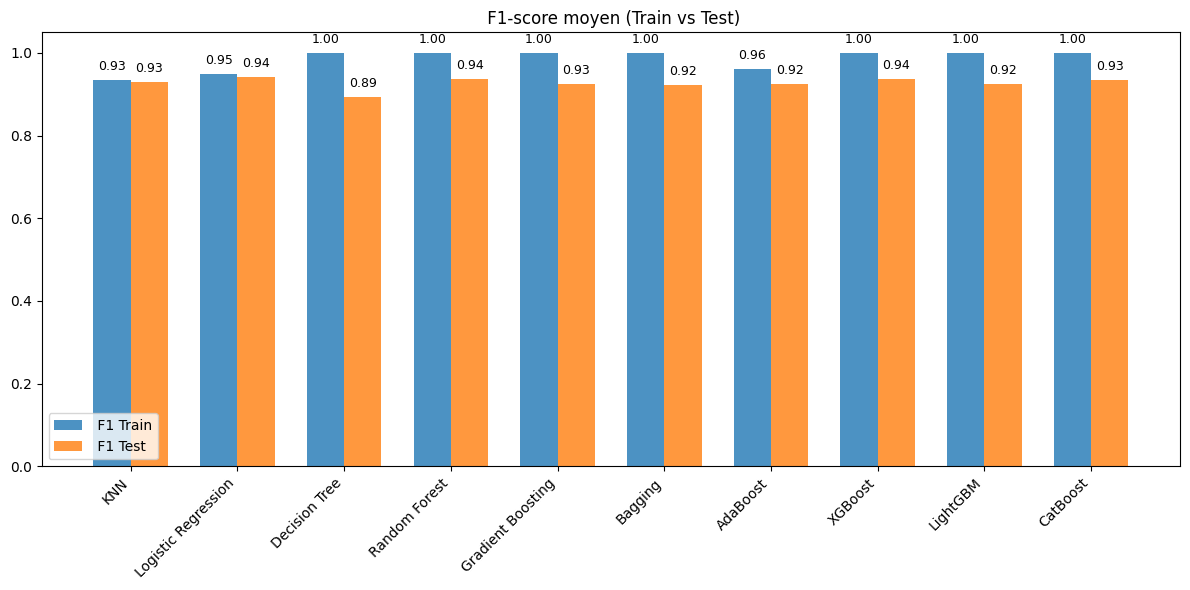

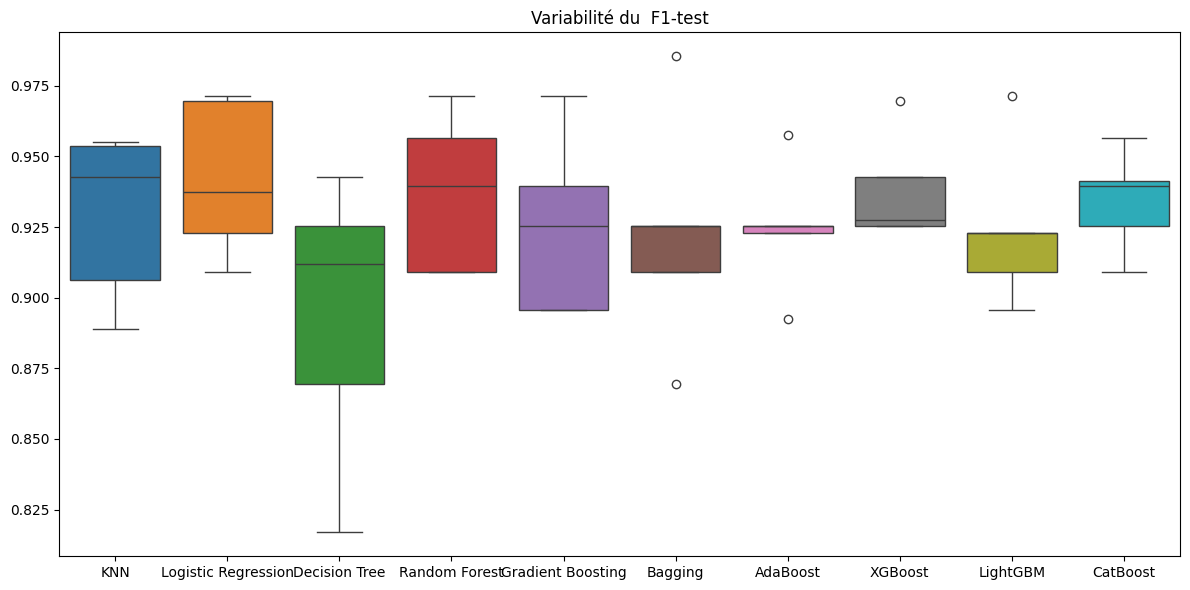

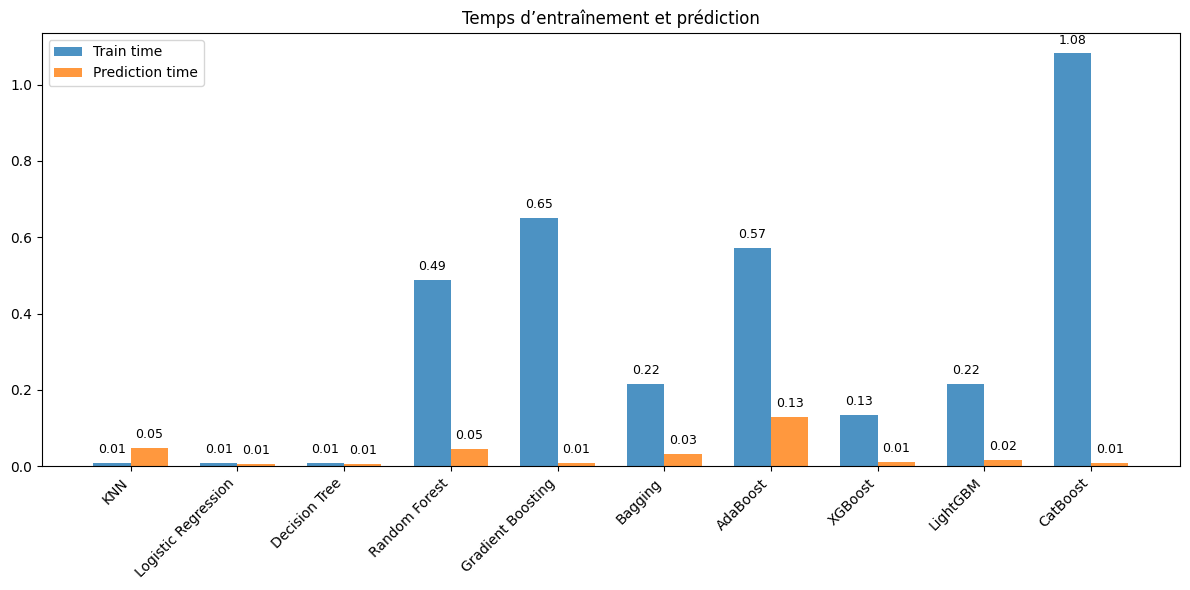

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.933891,0.929413,0.026917,0.007600,0.049201,0.926229
Logistic Regression,0.949576,0.942159,0.024877,0.009989,0.006200,0.939609
Decision Tree,1.000000,0.893292,0.045223,0.009408,0.005201,0.888718
Random Forest,1.000000,0.937105,0.025020,0.487219,0.045386,0.934149
Gradient Boosting,1.000000,0.925448,0.028635,0.650806,0.009793,0.922487
Bagging,0.999262,0.922982,0.037329,0.215329,0.031991,0.918929
AdaBoost,0.960311,0.924775,0.020712,0.572194,0.128208,0.921422
XGBoost,1.000000,0.938167,0.017068,0.133802,0.011797,0.936343
LightGBM,1.000000,0.924439,0.025626,0.215705,0.016801,0.921709
CatBoost,1.000000,0.934311,0.016014,1.081591,0.009192,0.932618


In [40]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['RFE']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

L’utilisation de RFE a simplifié le dataset en ne conservant que les variables les plus pertinentes, ce qui améliore la stabilité des modèles. Les résultats montrent :

La régression logistique devient la meilleure méthode (F1_test ≈ 0.94) grâce à un dataset plus linéaire et plus propre.
Random Forest et XGBoost restent performants (≈ 0.93–0.94) et relativement stables.
AdaBoost, LightGBM, Gradient Boosting et Bagging obtiennent des scores corrects (≈ 0.92–0.93) mais sont légèrement pénalisés par la perte d’interactions.
KNN et l’arbre de décision restent les moins efficaces, avec des performances plus faibles et une variabilité plus élevée.

En résumé, RFE favorise surtout les modèles linéaires et réduit l’impact des modèles complexes.

PCA


 Application de la méthode : PCA
 PCA : 84.94% de variance expliquée
→ Après PCA : 5 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.952 |  F1-test = 0.925
Temps entraînement = 0.0072s | Temps prédiction = 0.0502s

--- Modèle : Logistic Regression ---
 F1-train = 0.967 |  F1-test = 0.961
Temps entraînement = 0.0102s | Temps prédiction = 0.0074s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.890
Temps entraînement = 0.0096s | Temps prédiction = 0.0092s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.943
Temps entraînement = 0.5122s | Temps prédiction = 0.0502s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.930
Temps entraînement = 0.4750s | Temps prédiction = 0.0088s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.924
Temps entraînement = 0.1688s | Temps prédiction = 0.0278s

--- Modèle : AdaBoost ---
 F1-train = 0.969 |  F1-test = 0.923
Temps entraînement = 0.5102s

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:19:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.961
Temps entraînement = 0.5158s | Temps prédiction = 0.0108s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

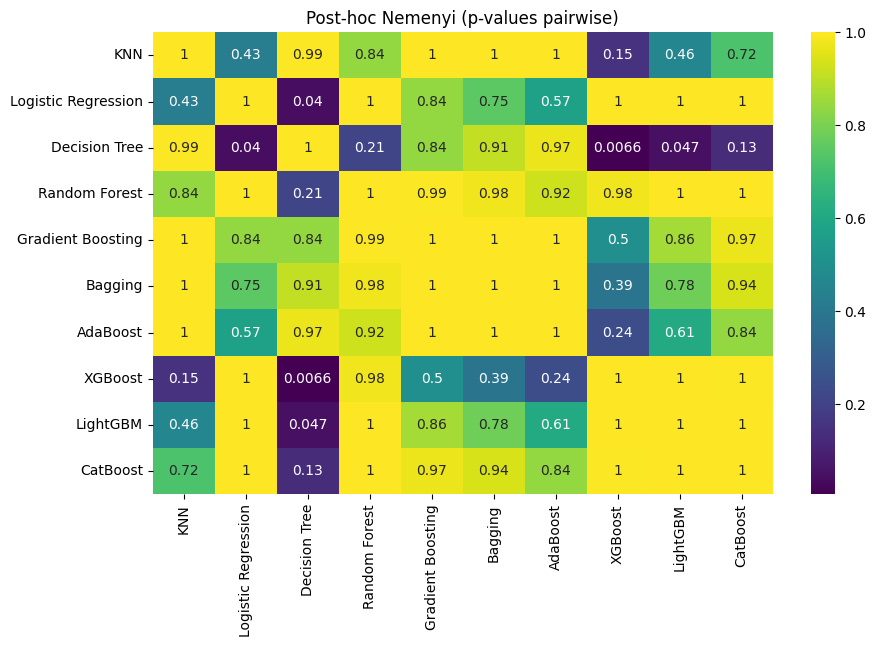

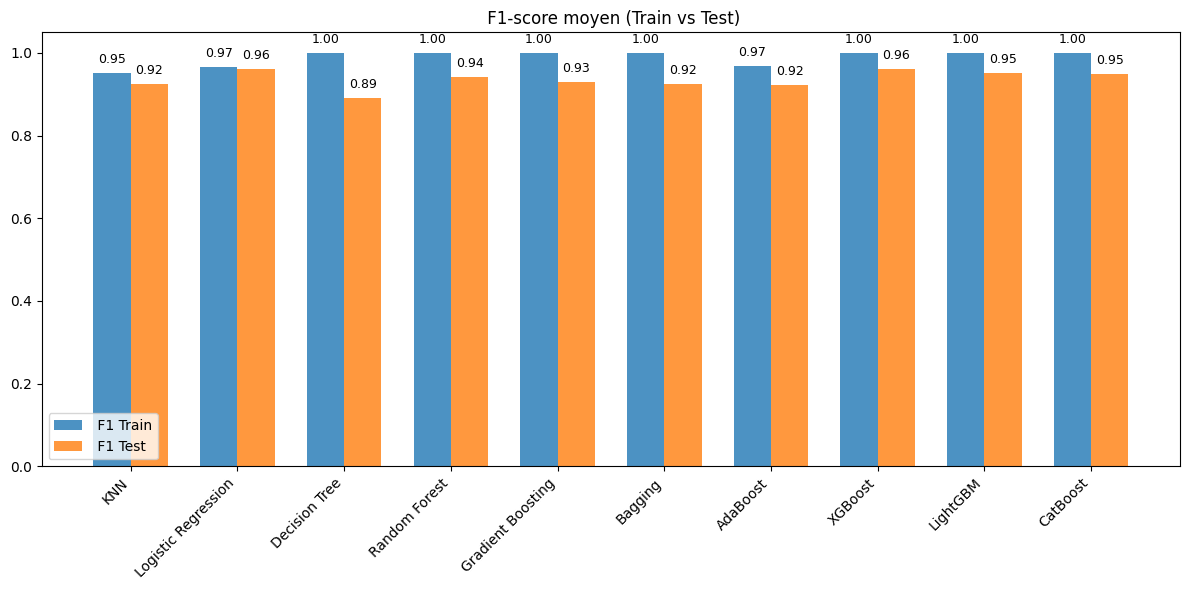

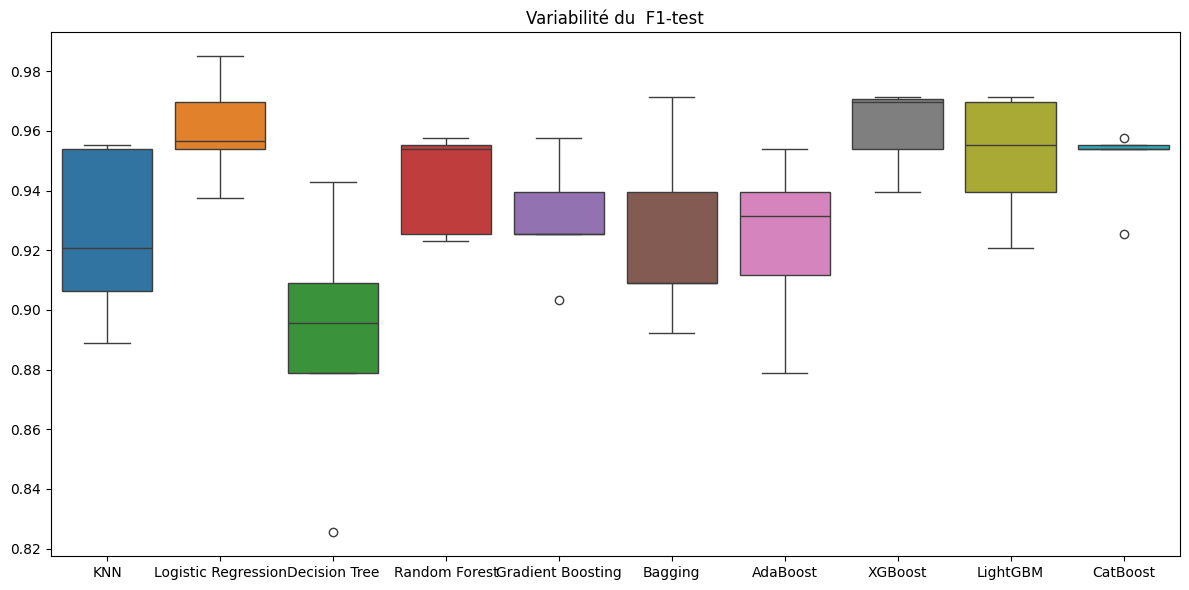

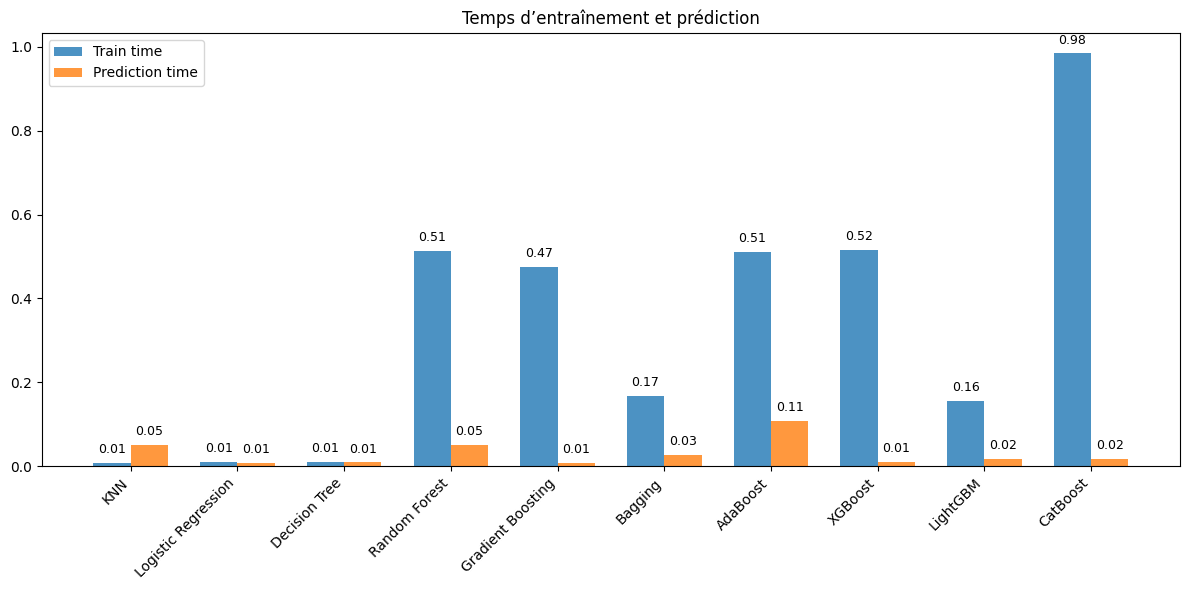

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.951786,0.924969,0.026154,0.007204,0.050197,0.921851
Logistic Regression,0.966848,0.960528,0.015985,0.010200,0.007400,0.958855
Decision Tree,1.000000,0.890331,0.038698,0.009601,0.009199,0.886369
Random Forest,1.000000,0.943053,0.015441,0.512194,0.050207,0.941007
Gradient Boosting,1.000000,0.930222,0.017986,0.474999,0.008799,0.928336
Bagging,1.000000,0.924262,0.028054,0.168800,0.027800,0.921179
AdaBoost,0.968937,0.923060,0.025975,0.510207,0.108009,0.919382
XGBoost,1.000000,0.960991,0.012604,0.515800,0.010799,0.959622
LightGBM,1.000000,0.951276,0.019189,0.155794,0.017003,0.949187
CatBoost,1.000000,0.949207,0.012002,0.983923,0.016998,0.947837


In [41]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['PCA']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

L’utilisation de la PCA a réduit la dimension du dataset tout en conservant l’essentiel de l’information, ce qui favorise les modèles sensibles aux relations globales.

XGBoost et la régression logistique deviennent les meilleurs modèles (F1_test ≈ 0.96), montrant que les composantes principales captent efficacement les structures discriminantes. Et le test de friedman montre qu'il n'y a pas de différence significative entre eux.

Random Forest, LightGBM et CatBoost restent solides (F1_test ≈ 0.94–0.95) avec une bonne stabilité.

KNN, Bagging, AdaBoost et Gradient Boosting obtiennent des performances intermédiaires (≈ 0.92–0.93), légèrement pénalisés par la nature linéaire de la PCA.

Decision Tree reste le moins performant, ayant du mal à exploiter des composantes globales moins locales.

ANOVA


 Application de la méthode : ANOVA
→ Après ANOVA : 10 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.937 |  F1-test = 0.917
Temps entraînement = 0.0086s | Temps prédiction = 0.0432s

--- Modèle : Logistic Regression ---
 F1-train = 0.936 |  F1-test = 0.935
Temps entraînement = 0.0114s | Temps prédiction = 0.0060s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.899
Temps entraînement = 0.0086s | Temps prédiction = 0.0058s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.935
Temps entraînement = 0.4466s | Temps prédiction = 0.0446s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.928
Temps entraînement = 0.6268s | Temps prédiction = 0.0080s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.912
Temps entraînement = 0.2068s | Temps prédiction = 0.0320s

--- Modèle : AdaBoost ---
 F1-train = 0.947 |  F1-test = 0.937
Temps entraînement = 0.6604s | Temps prédiction = 0.1148s



c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:20:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:20:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:20:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 0.999 |  F1-test = 0.937
Temps entraînement = 0.1364s | Temps prédiction = 0.0096s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.928
Temps entraînement = 1.1164s | Temps prédiction = 0.0092s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    0.999262
F1_test_mean     0.937076
F1_test_std      0.036038
Train_time       0.136399
Pred_time        0.009601
Score_global     0.933376
Name: XGBoost, dtype: float64



===== Test de Friedman =====
Statistique χ² = 16.0064
p-value        = 0.0667
→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).


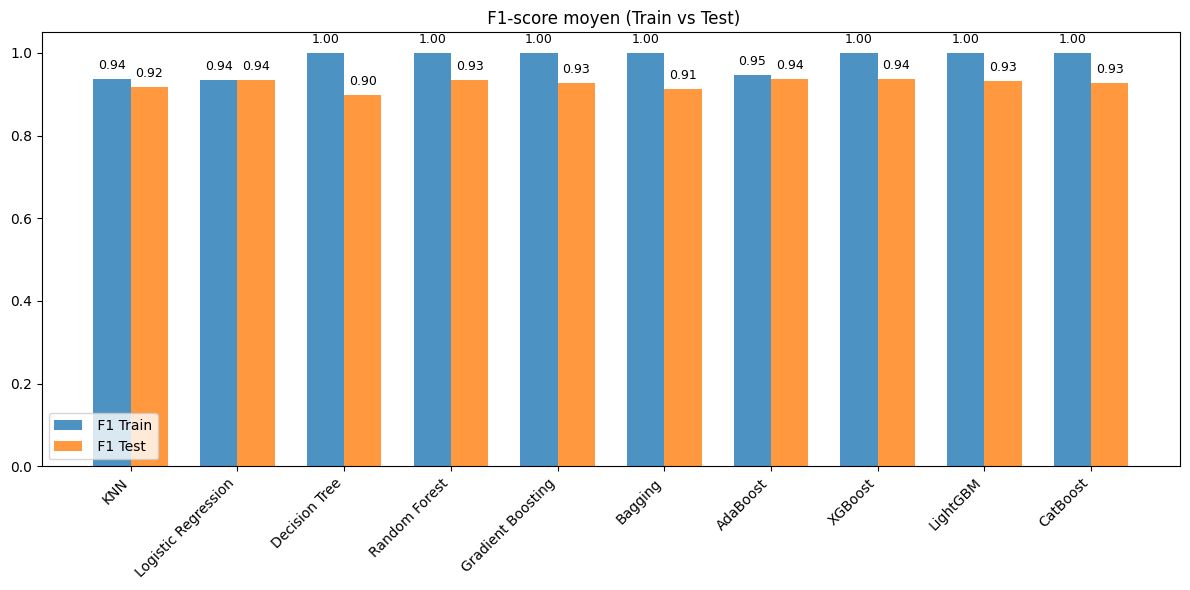

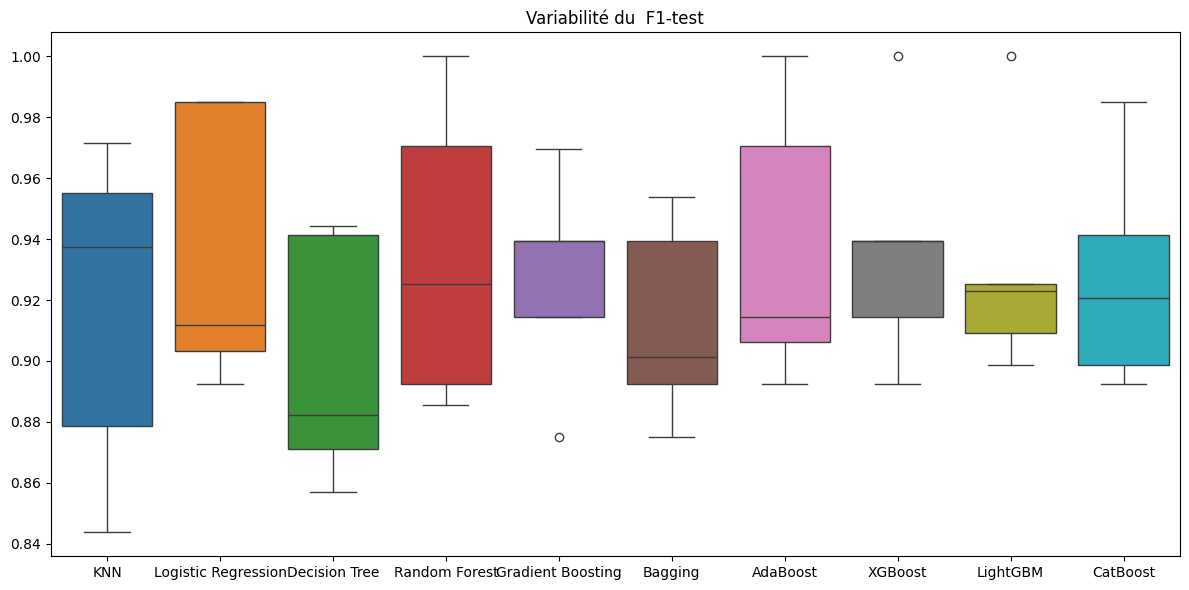

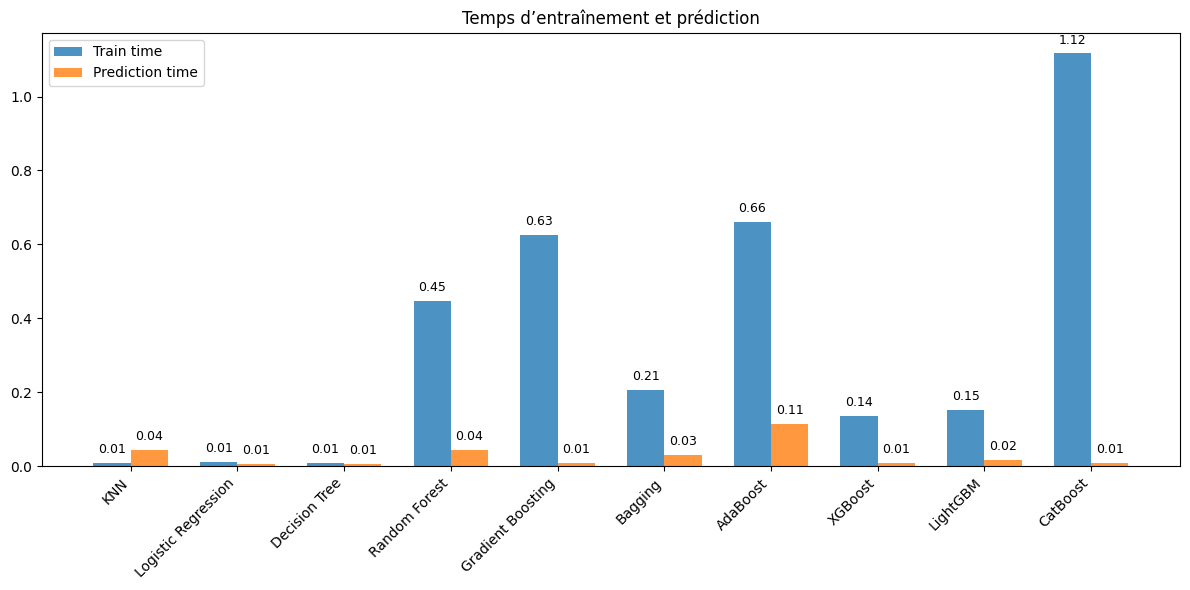

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.936573,0.917338,0.048309,0.008599,0.043192,0.912075
Logistic Regression,0.935590,0.935489,0.040953,0.011399,0.006004,0.931334
Decision Tree,1.000000,0.899217,0.036493,0.008598,0.005802,0.895510
Random Forest,1.000000,0.934797,0.044352,0.446614,0.044585,0.929916
Gradient Boosting,1.000000,0.927554,0.031605,0.626797,0.008007,0.924314
Bagging,0.999262,0.912391,0.029563,0.206810,0.031990,0.909115
AdaBoost,0.946590,0.936686,0.041366,0.660404,0.114801,0.931402
XGBoost,0.999262,0.937076,0.036038,0.136399,0.009601,0.933376
LightGBM,1.000000,0.931218,0.035744,0.151201,0.017400,0.927470
CatBoost,1.000000,0.927549,0.033543,1.116393,0.009193,0.924103


In [42]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['ANOVA']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

Avec la sélection ANOVA, les modèles d’ensemble restent les plus performants :
XGBoost, AdaBoost, Random Forest et Gradient Boosting obtiennent les meilleurs scores (F1_test ≈ 0.93–0.94).

La régression logistique est stable mais légèrement derrière (≈ 0.93).

LightGBM et CatBoost restent solides, mais un peu limités par la sélection de variables.

KNN, Bagging et surtout Decision Tree sont les moins compétitifs dans ce contexte.

**Conclusion générale**

PCA est la méthode la plus efficace : elle offre les meilleurs F1_test moyens, avec XGBoost (≈0.961) et Logistic Regression (≈0.960) en tête, tout en gardant une bonne stabilité et des temps d’exécution raisonnables.

RFE arrive en deuxième position : elle améliore surtout les modèles linéaires comme la régression logistique (≈0.942), mais elle pénalise légèrement les modèles complexes qui utilisent des interactions.

ANOVA est la moins performante : bien que correcte, elle donne des F1 plus faibles (≈0.93 max) et des écarts-types plus élevés, notamment pour Random Forest et Gradient Boosting.

En résumé : la PCA est la meilleure méthode de réduction, car c’est celle qui produit les scores les plus élevés et les plus stables, tout en profitant aux modèles les plus performants (XGBoost, Logistic Regression).

## 3. Optimisation des hyperparamètres via RandomizedSearchCV

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

# Création du scorer  F1
F1_scorer = make_scorer(f1_score )

def hyperparam_optimization(X, y, cv_splits=5, n_iter=50, random_state=42):
    """
    Recherche des meilleurs hyperparamètres pour plusieurs modèles de classification
    avec RandomizedSearchCV en utilisant le  F1-score.
    
    """

    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    preprocessor = ColumnTransformer([('num', StandardScaler(), numeric_features)], remainder='passthrough')

    # Dictionnaire des modèles et grilles de paramètres (exemple)
    model_params = {
        "Random Forest": {
            "model": RandomForestClassifier(random_state=random_state),
            "params": {
                "model__n_estimators": [100, 200, 500],
                "model__max_depth": [None, 5, 10],
                "model__max_features": ['sqrt', 'log2', 0.8]
            }
        },
        "Gradient Boosting": {
            "model": GradientBoostingClassifier(random_state=random_state),
            "params": {
                "model__n_estimators": [100, 200, 500],
                "model__learning_rate": [0.01, 0.1, 0.2],
                "model__max_depth": [3, 5, 7]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state),
            "params": {
                "model__n_estimators": [100, 200, 500],
                "model__learning_rate": [0.01, 0.1, 0.2],
                "model__max_depth": [3, 5, 7]
            }
        },
        "LightGBM": {
            "model": LGBMClassifier(random_state=random_state),
            "params": {
                "model__n_estimators": [100, 200, 500],
                "model__learning_rate": [0.01, 0.1, 0.2],
                "model__num_leaves": [31, 50, 100]
            }
        },
        "Logistic Regression": {
            "model": LogisticRegression(max_iter=5000, solver='lbfgs'),
            "params": {
                "model__C": [0.01, 0.1, 1, 10],
                "model__penalty": ['l2'],
                "model__solver": ['lbfgs']
            }
        }
    }

    best_models = {}
    best_params = {}

    for name, mp in model_params.items():
        print(f"\n--- Optimisation de {name} ---")
        pipeline = Pipeline([('preprocess', preprocessor), ('model', mp["model"])])

        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=mp["params"],
            scoring=F1_scorer,  # ou 'make_scorer(f1_score )'
            n_iter=n_iter,
            cv=cv_splits,
            verbose=1,
            random_state=random_state,
            n_jobs=-1
        )

        search.fit(X, y)
        best_models[name] = search.best_estimator_
        best_params[name] = search.best_params_
        print(f"→ Meilleurs paramètres : {search.best_params_}")
        print(f"→ Meilleur score  F1 : {search.best_score_:.4f}")

    return best_models, best_params


In [44]:
hyperparam_optimization(X_train, y_train)


--- Optimisation de Random Forest ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits
→ Meilleurs paramètres : {'model__n_estimators': 500, 'model__max_features': 0.8, 'model__max_depth': None}
→ Meilleur score  F1 : 0.9516

--- Optimisation de Gradient Boosting ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


→ Meilleurs paramètres : {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.2}
→ Meilleur score  F1 : 0.9470

--- Optimisation de XGBoost ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:24:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Meilleurs paramètres : {'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.1}
→ Meilleur score  F1 : 0.9586

--- Optimisation de LightGBM ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


→ Meilleurs paramètres : {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 10}
→ Meilleur score  F1 : 0.9611


({'Random Forest': Pipeline(steps=[('preprocess',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num', StandardScaler(),
                                                    ['radius1', 'texture1',
                                                     'perimeter1', 'area1',
                                                     'smoothness1',
                                                     'compactness1', 'concavity1',
                                                     'concave_points1',
                                                     'symmetry1',
                                                     'fractal_dimension1',
                                                     'radius2', 'texture2',
                                                     'perimeter2', 'area2',
                                                     'smoothness2',
                                                     'compactness2', 'conca

## Evaluation sur la partie test du modèle

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score,precision_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method=None,
    n_components=5,
    n_features=10
):

    #   1) Ajout du cluster KMeans  
    kmeans = KMeans(n_clusters=2, random_state=42)
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train["cluster"] = kmeans.fit_predict(X_train)
    X_test["cluster"] = kmeans.predict(X_test)

    #   2) Sélection du preprocess  
    numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
    preprocess = ColumnTransformer(
        [('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )

    #   3) Réduction dimensionnelle  
    reducer = None
    if reduction_method == "PCA":
        reducer = PCA(n_components=n_components)
    elif reduction_method == "ANOVA":
        reducer = SelectKBest(score_func=f_classif, k=n_features)
    elif reduction_method == "RFE":
        reducer = RFE(estimator=LogisticRegression(max_iter=2000), n_features_to_select=n_features)

    #   4) Meilleurs hyperparamètres  
    best_params = {
        'Random Forest': {'model__n_estimators': 500, 'model__max_features': 0.8, 'model__max_depth': None},
        'Gradient Boosting': {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.2},
        'XGBoost': {'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.1},
        'LightGBM': {'model__num_leaves': 31, 'model__n_estimators': 200, 'model__learning_rate': 0.2},
        'Logistic Regression': {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 10}
    }

    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "LightGBM": LGBMClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=3000)
    }

    #   5) Structure résultats  
    results = []

    print("\n  Entraînement direct sur train → test  \n")

    for name, model in models.items():

        print(f"--- Modèle : {name} ---")

        pipeline_steps = [("preprocess", preprocess)]
        if reducer is not None:
            pipeline_steps.append(("reducer", reducer))
        pipeline_steps.append(("model", model))

        pipe = Pipeline(pipeline_steps)

        # Chargement des meilleurs hyperparamètres
        pipe.set_params(**best_params[name])

        # Entraînement
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()

        # Prédiction
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        t2 = time.time()

        # Scores
        F1_train = f1_score(y_train, y_pred_train )
        F1_test = f1_score(y_test, y_pred_test )
        precision_score_test = precision_score(y_test, y_pred_test )
        recall_score_test = recall_score(y_test, y_pred_test )

        print(f" F1-train = {F1_train:.3f} |  F1-test = {F1_test:.3f}")
        print(f"Temps entraînement = {t1 - t0:.4f}s | Temps prédiction = {t2 - t1:.4f}s\n")

        results.append({
            "Model": name,
            "F1_train": F1_train,
            "F1_test": F1_test,
            "precision_score_test": precision_score_test,
            "recall_score_test": recall_score_test,
            "Train_time": t1 - t0,
            "Pred_time": t2 - t1,
            "Pipeline": pipe
        })

    results_df = pd.DataFrame(results)

    #   6) Graphiques  
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x="Model", y="F1_test")
    plt.title(" F1-test des modèles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Confusion matrix + ROC pour le meilleur modèle
    best = results_df.loc[results_df["F1_test"].idxmax()]
    best_model = best["Pipeline"]
    y_pred = best_model.predict(X_test)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion – {best['Model']}")
    plt.show()

    # ROC
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    else:
        y_proba = best_model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC – {best['Model']}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    print("\n  Meilleur modèle sur TEST  ")
    print(best[["Model", "F1_train", "F1_test"]])

    return results_df, best_model


In [ ]:
df, train, test, X_train, y_train, X_test, y_test = chargement_donnees_ucirepo()

In [ ]:
results_df, best_model=train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method=None
)
results_df=pd.DataFrame(results_df)
results_df.drop(columns=['Pipeline'])

Avec les techniques de réduction de dimension , on a trouvé que le PCA était le meilleur donc on va l'utiliser pour comparer

In [ ]:
results_df, best_model=train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method='PCA'
)
results_df=pd.DataFrame(results_df)
results_df.drop(columns=['Pipeline'])

**Interprétation des résultats**

Les performances montrent deux modèles en tête :

Random Forest et Logistic Regression, avec un F1_test ≈ 0.963, les meilleurs du tableau.

Cependant, leurs profils sont différents :

Random Forest atteint une précision parfaite (1.00) mais un rappel légèrement plus faible, avec un temps d’entraînement beaucoup plus élevé.

Logistic Regression obtient un excellent équilibre : précision 0.976, rappel 0.952, et des temps d’entraînement/prédiction extrêmement faibles.

Meilleur choix

Le meilleur modèle global est la **Régression Logistique**, car :

elle offre le meilleur F1_test (≈0.964),

elle maintient un très bon rappel (important pour ne pas rater les tumeurs),

elle est de loin la plus rapide et la plus simple à exploiter.

Conclusion opérationnelle

Pour un usage réel où la stabilité, la rapidité et la capacité à bien détecter les cas positifs sont essentielles, la Régression Logistique est le modèle le plus sûr et le plus performant sur vos données.